In [1]:
import h3
import pandas as pd
import numpy as np
import git

import shapely.geometry
from pyproj import Transformer
from pyproj import Geod
from shapely.ops import transform
from geopy.distance import geodesic
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Circle


In [2]:
# H3 cell areas by resolution (in m^2)
h3_areas = {res: h3.average_hexagon_area(res, unit="m^2") for res in range(16)}  # resolutions 0–15

# Function to get lowest H3 resolution that fits the area
def get_h3_resolution_for_area(area_m2):
    for res in sorted(h3_areas, reverse=True):
        if h3_areas[res] >= area_m2:
            return res
    return 5  # fallback to 5

In [3]:
def safe_latlng_to_cell(x):
    geor = x.get("georelated")
    if not geor:
        return None
    if isinstance(geor, dict):
        center = geor.get("center coordinates of affected area")
        area = geor.get("affected area in square km")
        if center is None:
            center = geor.get("center_coordinates_of_affected_area")
        if area is None:
            area = geor.get("affected_area_in_square_km")
    else:
        center = None
        area = None
    if not center:
        return None
    lat = center.get("latitude") if isinstance(center, dict) else None
    lng = center.get("longitude") if isinstance(center, dict) else None
    # Also check for None here:
    if lat is None or lng is None or area is None:
        return None
    try:
        return h3.latlng_to_cell(
            lat=float(lat),
            lng=float(lng),
            res=get_h3_resolution_for_area(float(area) * 1e6),
        )
    except Exception as e:
        return None

def get_cell_relation(pred_cell, trajector_cell_index) -> str:
    """
    Determines the relationship between two H3 cells.
    :param pred_cell: The predicted H3 cell.
    :param trajector_cell_index: The ground truth H3 cell.
    :return: A string indicating the relationship.
    """

    if pred_cell == trajector_cell_index:
        return "identical"

    # Get their resolutions
    pred_res = h3.get_resolution(pred_cell)
    gt_res = h3.get_resolution(trajector_cell_index)

    if pred_res == gt_res:
        if h3.are_neighbor_cells(pred_cell, trajector_cell_index):
            return "same_resolution_neighbor"
        else:
            return "disjoint_same_resolution"
    elif pred_res < gt_res:
        inferred_parent = h3.cell_to_parent(trajector_cell_index, pred_res)
        if pred_cell == inferred_parent:
            return "parent"
        else:
            if h3.are_neighbor_cells(pred_cell, inferred_parent):
                return "coarser_neighbor"
            return "disjoint_coarser_resolution"
    else:
        inferred_parent = h3.cell_to_parent(pred_cell, gt_res)
        if trajector_cell_index == inferred_parent:
            return "child"
        else:
            if h3.are_neighbor_cells(trajector_cell_index, inferred_parent):
                return "finer_neighbor"
            return "disjoint_finer_resolution"

In [4]:
def calculate_metrics(df, k=50):
    """
    Calculate various metrics for the georelated DataFrame.
    :param df: DataFrame containing georelated data.
    :param k: Accuracy threshold in km.
    :return: Dictionary of calculated metrics.
    """

    project = Transformer.from_crs('epsg:4326', 'epsg:6933', always_xy=True).transform

    # Prepare DataFrame columns for results (if not present)
    for col in ["error_distance", "pred_area_6933", "gt_area_6933", "intersection_area_6933"]:
        if col not in df.columns:
            df[col] = np.nan

    all_log_q_area = []
    all_log_q_distance = []

    # Initialize counts
    counts = {
        'identical': 0,
        'parent': 0,
        'child': 0,
        'coarser_neighbor': 0,
        'same_resolution_neighbor': 0,
        'finer_neighbor': 0,
        'disjoint_same_resolution': 0,
        'disjoint_coarser_resolution': 0,
        'disjoint_finer_resolution': 0
    }

    # Calculate all metrics row-wise, store in DataFrame
    for index, row in df.iterrows():
        if row.get('pred_cell') is None or row.get('trajector_cell_index') is None:
            continue

        # Parse coordinates
        gt_lat, gt_lon = map(float, map(str.strip, row["trajector_center"].split(",")))
        gt_coordinates = (gt_lat, gt_lon)
        try:
            pred_center = row['georelated']['center coordinates of affected area']
        except KeyError as e:
            pred_center = row['georelated']['center_coordinates_of_affected_area']
        predicted_coordinates = (pred_center['latitude'], pred_center['longitude'])

        # Geodesic error in km
        error_distance = geodesic(gt_coordinates, predicted_coordinates).kilometers
        df.at[index, "error_distance"] = error_distance

        # H3 cell shapes
        pred_shape = h3.cells_to_h3shape([row['pred_cell']])
        target_shape = h3.cells_to_h3shape([row['trajector_cell_index']])
        pred_poly = shapely.geometry.shape(h3.h3shape_to_geo(pred_shape))
        target_poly = shapely.geometry.shape(h3.h3shape_to_geo(target_shape))

        # Project to equal-area CRS
        pred_poly_proj = transform(project, pred_poly)
        target_poly_proj = transform(project, target_poly)
        pred_area_m2 = pred_poly_proj.area
        gt_area_m2   = target_poly_proj.area

        df.at[index, "pred_area_6933"] = pred_area_m2
        df.at[index, "gt_area_6933"] = gt_area_m2

        # Intersection area
        intersection = pred_poly_proj.intersection(target_poly_proj)
        intersection_area = intersection.area
        df.at[index, "intersection_area_6933"] = intersection_area

        relation = row['cell_relation']
        if relation in counts:
            counts[relation] += 1

        # Calculate proportion metrics for this row (if appropriate)
        try:
            log_q_area = np.log(pred_area_m2 / gt_area_m2)
            all_log_q_area.append(log_q_area)
            # if not nan
            if not np.isnan(row['distance_to_landmark']):
                denom = row['distance_to_landmark'] + 1e-5
                numer = row['pred_distance']

                if denom <= 0 or numer <= 0:
                    log_q_distance = np.nan
                else:
                    log_q_distance = np.log(numer / denom)
                all_log_q_distance.append(log_q_distance)
        except Exception:
            all_log_q_area.append(np.nan)

    ####### Aggregate Metrics ########

    # Remove NaNs
    all_error_distances = df["error_distance"].dropna().values
    all_log_q_area = np.array([x for x in all_log_q_area if not np.isnan(x)])
    all_log_q_distance = np.array([x for x in all_log_q_distance if not np.isnan(x)])

    # ACCURACY@k
    within_k = (all_error_distances <= k)
    accuracy_at_k = within_k.mean()
    strict_accuracy_at_k = np.sum(within_k) / len(df)

    # AUC function as before
    def calculate_auc(sorted_values):
        max_error = 20038  # Earth's circumference in km / 2
        size = len(sorted_values)
        if size <= 1:
            return 0.0
        h = 1  # step size
        log_max = np.log(max_error)
        auc = 0.5 * ((np.log(1 + sorted_values[0]) + np.log(1 + sorted_values[-1])) / log_max)
        for v in sorted_values[1:-1]:
            auc += np.log(1 + v) / log_max
        auc = auc * h / (size - 1)
        return auc

    sorted_error_distances = np.sort(all_error_distances)
    auc = calculate_auc(sorted_error_distances)

    # Mean/Median error
    mean_error_distance = np.mean(all_error_distances)
    median_error_distance = np.median(all_error_distances)

    # ζ Median Symmetric Accuracy
    zeta = 100 * (np.exp(np.median(np.abs(all_log_q_area))) - 1)

    # SSPB
    sspb = 100 * np.sign(np.median(all_log_q_area)) * (np.exp(np.abs(np.median(all_log_q_area))) - 1)

    valid = (
        (df['intersection_area_6933'] > 0) &
        (df['pred_area_6933'] > 0) &
        (df['gt_area_6933'] > 0)
    )
    average_precision = (df.loc[valid, 'intersection_area_6933'] / df.loc[valid, 'pred_area_6933']).mean()
    average_recall = (df.loc[valid, 'intersection_area_6933'] / df.loc[valid, 'gt_area_6933']).mean()
    average_f1 = 2 * average_precision * average_recall / (average_precision + average_recall)

    # distance metrics
    # ζ Median Symmetric Accuracy
    zeta_distance = 100 * (np.exp(np.median(np.abs(all_log_q_distance))) - 1)

    # SSPB
    sspb_distance = 100 * np.sign(np.median(all_log_q_distance)) * (np.exp(np.abs(np.median(all_log_q_distance))) - 1)


    # Calculate cell-based metrics
    total = sum(counts.values())
    fuzzy_cell_match_score = 1 - (counts['disjoint_coarser_resolution'] + counts['disjoint_finer_resolution'] + counts['disjoint_same_resolution']) / total if total else 0
    exact_cell_match_score = counts['identical'] / total if total else 0
    cell_overlap_score = (counts['parent'] + counts['child'] + counts['identical']) / total if total else 0
    cell_level_accuracy = (counts['identical'] + counts['disjoint_same_resolution'] + counts['same_resolution_neighbor']) / total if total else 0
    count_finer = counts['child'] + counts['finer_neighbor'] + counts['disjoint_finer_resolution']
    count_coarser = counts['parent'] + counts['coarser_neighbor'] + counts['disjoint_coarser_resolution']
    cell_level_bias = (count_coarser - count_finer) / total if total else 0

    # Return all metrics
    return {
        'fuzzy_cell_match_score': fuzzy_cell_match_score,
        'exact_cell_match_score': exact_cell_match_score,
        'cell_overlap_score': cell_overlap_score,
        'cell_level_accuracy': cell_level_accuracy,
        'cell_level_bias': cell_level_bias,
        f"accuracy@{k}": accuracy_at_k,
        f"strict_accuracy@{k}": strict_accuracy_at_k,
        "auc": auc,
        "mean_error_distance": mean_error_distance,
        "median_error_distance": median_error_distance,
        "area_zeta": zeta,
        "area_sspb": sspb,
        "average_precision": average_precision,
        "average_recall": average_recall,
        "average_f1": average_f1,
        "distance_zeta": zeta_distance,
        "distance_sspb": sspb_distance
    }

In [5]:
def calc_azimuth_distance(row, geod=Geod(ellps="WGS84")):
    try:
        # Check if coordinates are missing (None or not a dict)
        center = row["georelated"].get("center coordinates of affected area")
        if center is None:
            center = row["georelated"].get("center_coordinates_of_affected_area")
        if center is None:
            return pd.Series({'forward_azimuth': None, 'pred_distance': None})
        fwd_azimuth, _, dist = geod.inv(
            row["landmark_longitude"],
            row["landmark_latitude"],
            center["longitude"],
            center["latitude"]
        )
        # Normalize azimuth to 0-360°
        fwd_azimuth = (fwd_azimuth + 360) % 360
        return pd.Series({'forward_azimuth': fwd_azimuth, 'pred_distance': dist})
    except Exception:
        # Catch possible missing keys or bad values
        return pd.Series({'forward_azimuth': None, 'pred_distance': None})

In [6]:
compass_dirs = {
    'north': (337.5, 22.5),
    'northeast': (22.5, 67.5),
    'east': (67.5, 112.5),
    'southeast': (112.5, 157.5),
    'south': (157.5, 202.5),
    'southwest': (202.5, 247.5),
    'west': (247.5, 292.5),
    'northwest': (292.5, 337.5)
}

dir_colors = {
    'north': '#b2182b',
    'northeast': '#f1b6da',
    'east': '#c51b7d',
    'southeast': '#9970ab',
    'south': '#2166ac',
    'southwest': '#80cdc1',
    'west': '#1a7837',
    'northwest': '#dfc27d'
}

def azimuth_to_direction(azimuth):
    if np.isnan(azimuth):
        return np.nan
    for direction, (start, end) in compass_dirs.items():
        if start > end:
            if azimuth >= start or azimuth < end:
                return direction
        else:
            if start <= azimuth < end:
                return direction
    return 'north'

def plot_azimuth_visualization(
    df,
    azimuth_bin_size=15,
    distance_bin_size=0.1,
    upper_bound=0.9,
    lower_bound=0.1,
    focus_directions=None,
    plot_type='all_in_one',
    viz_file_name=None,
):

    df['distance_ratio'] = df["pred_distance"] / df["distance_to_landmark"]
    lower_bound = df['distance_ratio'].quantile(lower_bound)
    upper_bound = df['distance_ratio'].quantile(upper_bound)
    df = df[(df['distance_ratio'] >= lower_bound) & (df['distance_ratio'] <= upper_bound)]

    df['azimuth_bin'] = (df['forward_azimuth'] // azimuth_bin_size * azimuth_bin_size).astype(int)
    df['ratio_bin'] = (df['distance_ratio'] // distance_bin_size * distance_bin_size).round(2)
    df['gt_direction'] = df['azimuth'].apply(azimuth_to_direction)

    grouped = df.groupby(['azimuth_bin', 'ratio_bin', 'gt_direction']).size().reset_index(name='count')
    grouped['theta'] = np.deg2rad(grouped['azimuth_bin'])
    grouped['r'] = grouped['ratio_bin']
    inner_radius = 0.1
    grouped['r_plot'] = grouped['r'] + inner_radius
    grouped['bin_idx'] = grouped.groupby('azimuth_bin').cumcount()
    grouped['theta_offset'] = grouped['bin_idx'] * (azimuth_bin_size * np.pi / 180) / 10
    grouped['theta_final'] = grouped['theta'] + grouped['theta_offset'] - grouped['theta_offset'].mean()
    max_count = grouped['count'].max()
    min_width = 0.005
    grouped['width'] = np.maximum((grouped['count'] / max_count) * (azimuth_bin_size * np.pi / 180) * 0.9, min_width)

    sns.set_theme(style="white", context="notebook", font_scale=1.2)
    if plot_type == 'all_in_one':
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 12), facecolor='w')

        # Draw ground truth reference circle with radius (1.0 + inner_radius)
        theta_line = np.linspace(0, 2*np.pi, 360)
        ax.plot(theta_line, np.full_like(theta_line, 1.0 + inner_radius), "k-", linewidth=1.5)

        for _, row in grouped.iterrows():
            color = dir_colors.get(row['gt_direction'], 'gray')
            ax.bar(
                x=row['theta_final'],
                height=row['r'],
                width=row['width'],
                bottom=inner_radius,
                color=color,
                alpha=1.0,
                edgecolor='none'
            )

        ax.set_theta_zero_location("N")
        ax.set_theta_direction("clockwise")
        r_max = grouped['r_plot'].max() + 0.1
        ax.set_ylim(0, r_max)

        tick_locations = [inner_radius + x for x in [0, 0.5, 1.0, 1.5, 2.0, 2.5]]
        ax.set_yticks(tick_locations)
        ax.set_yticklabels([f"{(t - inner_radius)*100:.0f}%" for t in tick_locations])
        ax.set_rlabel_position(15)

        for label in ax.get_yticklabels():
            if label.get_text() == "100%":
                label.set_fontweight("bold")

        ax.set_title("Model Performance by Azimuth\n", fontsize=18, fontweight='bold')

        circle = Circle((0, 0), inner_radius, transform=ax.transData._b, facecolor='white', edgecolor='none', zorder=5)
        ax.add_artist(circle)

        ytick_lines = [
            Line2D([0], [0], color="gray", linewidth=1.5, label="0%: prediction on landmark"),
            Line2D([0], [0], color="gray", linewidth=1.5, label="0 < r < 100%: prediction too short"),
            Line2D([0], [0], color="black", linewidth=1.5, label="100%: prediction == true distance"),
            Line2D([0], [0], color="gray", linewidth=1.5, label="r > 100%: prediction too long")
        ]

        distance_ratio_legend = ax.legend(
            handles=ytick_lines,
            title="Trajector distance ratio",
            loc='lower center', bbox_to_anchor=(0.89, 0.9), ncol=1
        )
        distance_ratio_legend.get_title().set_ha('center')
        distance_ratio_legend.set_title("Trajector distance ratio", prop={'weight':'bold'})
        ax.add_artist(distance_ratio_legend)

        legend_patches = [Patch(color=color, label=dir.title()) for dir, color in dir_colors.items()]
        ax.legend(handles=legend_patches,
                  title="Ground truth direction",
                  loc='lower center',
                  bbox_to_anchor=(0.5, -0.11), ncol=4)
        ax.get_legend().get_title().set_fontweight('bold')
        ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
        ax.set_xticklabels(['North', 'East', 'South', 'West'], fontsize=12, ha='center')
        ax.spines['polar'].set_visible(False)

        plt.tight_layout()
        plt.show()

    elif plot_type == 'subplots':
        if focus_directions is None:
            focus_directions = list(compass_dirs.keys())

        num_directions = len(focus_directions)
        fig, axes = plt.subplots(num_directions, 1, subplot_kw={'projection': 'polar'}, figsize=(5, num_directions * 5))
        plt.subplots_adjust(hspace=0.3, wspace=0.3)

        if num_directions == 1:
            axes = [axes]  # Fix the axes in case there's only one subplot

        for i, direction in enumerate(focus_directions):
            df_dir = df[df['gt_direction'] == direction]

            grouped_dir = df_dir.groupby(['azimuth_bin', 'ratio_bin', 'gt_direction']).size().reset_index(name='count')
            grouped_dir['theta'] = np.deg2rad(grouped_dir['azimuth_bin'])
            grouped_dir['r'] = grouped_dir['ratio_bin']
            grouped_dir['r_plot'] = grouped_dir['r'] + inner_radius

            grouped_dir['bin_idx'] = grouped_dir.groupby('azimuth_bin').cumcount()
            grouped_dir['theta_offset'] = grouped_dir['bin_idx'] * (azimuth_bin_size * np.pi / 180) / 10
            grouped_dir['theta_final'] = grouped_dir['theta'] + grouped_dir['theta_offset'] - grouped_dir['theta_offset'].mean()

            max_count_dir = grouped_dir['count'].max()
            grouped_dir['width'] = np.maximum((grouped_dir['count'] / max_count_dir) * (azimuth_bin_size * np.pi / 180) * 0.9, min_width)

            ax = axes[i]
            theta_line = np.linspace(0, 2*np.pi, 360)
            ax.plot(theta_line, np.full_like(theta_line, 1.0 + inner_radius), "k-", linewidth=1.5)

            for _, row in grouped_dir.iterrows():
                color = dir_colors.get(row['gt_direction'], 'gray')
                ax.bar(
                    x=row['theta_final'],
                    height=row['r'],
                    width=row['width'],
                    bottom=inner_radius,
                    color=color,
                    alpha=1.0,
                    edgecolor='none',
                    zorder=0
                )

            ax.set_theta_zero_location("N")
            ax.set_theta_direction("clockwise")
            r_max_dir = grouped_dir['r_plot'].max() + 0.1
            ax.set_ylim(0, r_max_dir)

            tick_locations = [inner_radius + x for x in [0, 0.5, 1.0, 1.5, 2.0, 2.5]]
            ax.set_yticks(tick_locations)
            # display y-ticklabels in front of plotted bars
            ax.set_yticklabels([f"{(t - inner_radius)*100:.0f}%" for t in tick_locations], fontsize=9)
            ax.tick_params(axis='y', which='both', direction='out', zorder=3)
            ax.set_rlabel_position(15)

            for label in ax.get_yticklabels():
                label.set_fontweight("bold" if label.get_text() == "100%" else "normal")

            ax.set_title(f"{direction.title()}", fontsize=18, fontweight='bold')

            circle = Circle((0, 0), inner_radius, transform=ax.transData._b, facecolor='white', edgecolor='none', zorder=1)
            ax.add_artist(circle)

            ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
            ax.set_xticklabels(['N', 'E', 'S', 'W'], fontsize=10, ha='center')
            ax.spines['polar'].set_visible(False)

        # Display the distance ratio legend only once
        ytick_lines = [
            Line2D([0], [0], color="gray", linewidth=1.5, label="0%: prediction on landmark"),
            Line2D([0], [0], color="gray", linewidth=1.5, label="0 < r < 100%: prediction too short"),
            Line2D([0], [0], color="black", linewidth=1.5, label="100%: prediction == true distance"),
            Line2D([0], [0], color="gray", linewidth=1.5, label="r > 100%: prediction too long")
        ]

        fig.legend(
            handles=ytick_lines,
            title="Trajector distance ratio",
            loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=int(num_directions),
            prop={'weight':'bold'}
        )
        plt.tight_layout()
        plt.savefig(viz_file_name, dpi=500)
        plt.show()

In [7]:
def plot_direction_confusion_matrix(
    df,
    azimuth_col,        # Column name for azimuths (e.g., 'forward_azimuth')
    gold_col,           # Column name for gold labels (e.g., 'spatial_relation')
    azimuth_to_direction,  # Function to convert azimuth to direction label
    compass_dirs         # Dict of valid labels, e.g. {'N': 0, 'NE': 1, ...}
):
    # Generate predicted direction
    df = df.copy()
    df['pred_direction'] = df[azimuth_col].apply(azimuth_to_direction)

    # Drop rows where either is NaN
    mask = df[gold_col].notna() & df['pred_direction'].notna()
    filtered = df[mask].copy()

    # Convert to string and drop string 'nan'
    filtered[gold_col] = filtered[gold_col].astype(str)
    filtered['pred_direction'] = filtered['pred_direction'].astype(str)
    filtered = filtered[
        (filtered[gold_col].str.lower() != 'nan') &
        (filtered['pred_direction'].str.lower() != 'nan')
    ]

    # Keep only valid labels
    valid_labels = set(compass_dirs.keys())
    filtered = filtered[
        filtered[gold_col].isin(valid_labels) &
        filtered['pred_direction'].isin(valid_labels)
    ]

    # Compute the confusion matrix
    labels = list(compass_dirs.keys())
    conf_matrix = confusion_matrix(
        filtered[gold_col],
        filtered['pred_direction'],
        labels=labels
    )
    # Calculate ratios (percentages)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero
    conf_matrix_percentage = np.divide(conf_matrix, row_sums, out=np.zeros_like(conf_matrix, dtype=float), where=row_sums!=0)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, cmap='Blues', fmt='.2f',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Directions')
    plt.ylabel('Actual Directions')
    plt.title('Confusion Matrix as Percentages')
    plt.show()

In [ ]:
repo_root = git.Repo('.', search_parent_directories=True).working_tree_dir

georelated_df_us = pd.read_json(fr"{repo_root}/output/georelating/processed_deepseek-r1-distill-llama-70b_2_20250523_cleaned_georelating_dataset_us_enriched.json", orient='records')

georelated_df_eu = pd.read_json(fr"{repo_root}/output/georelating/processed_deepseek-r1-distill-llama-70b_2_20250523_cleaned_georelating_dataset_eu_enriched.json", orient='records')

georelated_df_us['pred_cell'] = georelated_df_us.apply(safe_latlng_to_cell, axis=1)
georelated_df_us['pred_cell_area'] = georelated_df_us.apply(lambda x: h3.cell_area(x['pred_cell'], unit="m^2") if x['pred_cell'] else None, axis=1)
georelated_df_us['cell_relation'] = georelated_df_us.apply(lambda x: get_cell_relation(x['pred_cell'], x['trajector_cell_index']) if x['pred_cell'] and x['trajector_cell_index'] else None, axis=1)
georelated_df_us[["forward_azimuth", "pred_distance"]] = georelated_df_us.apply(calc_azimuth_distance, axis=1)

georelated_df_eu['pred_cell'] = georelated_df_eu.apply(safe_latlng_to_cell, axis=1)
georelated_df_eu['pred_cell_area'] = georelated_df_eu.apply(lambda x: h3.cell_area(x['pred_cell'], unit="m^2") if x['pred_cell'] else None, axis=1)
georelated_df_eu['cell_relation'] = georelated_df_eu.apply(lambda x: get_cell_relation(x['pred_cell'], x['trajector_cell_index']) if x['pred_cell'] and x['trajector_cell_index'] else None, axis=1)
georelated_df_eu[["forward_azimuth", "pred_distance"]] = georelated_df_eu.apply(calc_azimuth_distance, axis=1)

georelated_df_us_llama = pd.read_json(fr"{repo_root}/output/georelating/processed_llama-3.3-70b-instruct_2_20250523_cleaned_georelating_dataset_us_enriched.json", orient='records')

georelated_df_eu_llama = pd.read_json(fr"{repo_root}/output/georelating/processed_llama-3.3-70b-instruct_2_20250523_cleaned_georelating_dataset_eu_enriched.json", orient='records')

georelated_df_us_llama['pred_cell'] = georelated_df_us_llama.apply(safe_latlng_to_cell, axis=1)
georelated_df_us_llama['pred_cell_area'] = georelated_df_us_llama.apply(lambda x: h3.cell_area(x['pred_cell'], unit="m^2") if x['pred_cell'] else None, axis=1)
georelated_df_us_llama['cell_relation'] = georelated_df_us_llama.apply(lambda x: get_cell_relation(x['pred_cell'], x['trajector_cell_index']) if x['pred_cell'] and x['trajector_cell_index'] else None, axis=1)
georelated_df_us_llama[["forward_azimuth", "pred_distance"]] = georelated_df_us_llama.apply(calc_azimuth_distance, axis=1)

georelated_df_eu_llama['pred_cell'] = georelated_df_eu_llama.apply(safe_latlng_to_cell, axis=1)
georelated_df_eu_llama['pred_cell_area'] = georelated_df_eu_llama.apply(lambda x: h3.cell_area(x['pred_cell'], unit="m^2") if x['pred_cell'] else None, axis=1)
georelated_df_eu_llama['cell_relation'] = georelated_df_eu_llama.apply(lambda x: get_cell_relation(x['pred_cell'], x['trajector_cell_index']) if x['pred_cell'] and x['trajector_cell_index'] else None, axis=1)
georelated_df_eu_llama[["forward_azimuth", "pred_distance"]] = georelated_df_eu_llama.apply(calc_azimuth_distance, axis=1)

georelated_df = pd.concat([georelated_df_us, georelated_df_eu])
georelated_df_llama = pd.concat([georelated_df_us_llama, georelated_df_eu_llama])


metrics = calculate_metrics(georelated_df, k=10)
for key, value in metrics.items():
    print(f"{key}: {value:.3f}")


In [11]:
def calculate_cell_relation_metrics(georelated_df, natural_disasters):
    # Initialize dictionary to store metrics for each disaster
    metrics_list = []

    # Iterate over each natural disaster and compute the required metrics
    for disaster in natural_disasters:
        disaster_sub_df = georelated_df[georelated_df['natural_disaster'] == disaster]

        # Initialize counts
        counts = {
            'identical': 0,
            'parent': 0,
            'child': 0,
            'coarser_neighbor': 0,
            'same_resolution_neighbor': 0,
            'finer_neighbor': 0,
            'disjoint_same_resolution': 0,
            'disjoint_coarser_resolution': 0,
            'disjoint_finer_resolution': 0
        }

        for _, row in disaster_sub_df.iterrows():
            relation = row['cell_relation']
            if relation in counts:
                counts[relation] += 1

        # Calculate metrics
        total = sum(counts.values())
        fuzzy_cell_match_score = 1 - (counts['disjoint_coarser_resolution'] + counts['disjoint_finer_resolution'] + counts['disjoint_same_resolution']) / total if total else 0
        exact_cell_match_score = counts['identical'] / total if total else 0
        cell_overlap_score = (counts['parent'] + counts['child'] + counts['identical']) / total if total else 0
        cell_level_accuracy = (counts['identical'] + counts['disjoint_same_resolution'] + counts['same_resolution_neighbor']) / total if total else 0
        count_finer = counts['child'] + counts['finer_neighbor'] + counts['disjoint_finer_resolution']
        count_coarser = counts['parent'] + counts['coarser_neighbor'] + counts['disjoint_coarser_resolution']
        cell_level_bias = (count_coarser - count_finer) / total if total else 0


        # Store the metrics in the dictionary
        metrics_list.append({
            'disaster': disaster,
            'fuzzy_cell_match_score': fuzzy_cell_match_score,
            'exact_cell_match_score': exact_cell_match_score,
            'cell_overlap_score': cell_overlap_score,
            'cell_level_accuracy': cell_level_accuracy,
            'cell_level_bias': cell_level_bias,
        })

    # Convert metrics list to DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df

# Usage
natural_disasters = ['landslide', 'storm', 'flood', 'wild fire']
cell_relation_metrics_global = calculate_cell_relation_metrics(georelated_df, natural_disasters)

# print the cell relation metrics
print(cell_relation_metrics_global)

fuzzy_cell_match_score: 0.825
exact_cell_match_score: 0.220
cell_overlap_score: 0.608
cell_level_accuracy: 0.381
cell_level_bias: 0.277
accuracy@10: 0.874
strict_accuracy@10: 0.843
auc: 0.111
mean_error_distance: 35.311
median_error_distance: 1.110
area_zeta: 599.736
area_sspb: 0.030
average_precision: 0.493
average_recall: 0.737
average_f1: 0.591
distance_zeta: 24.246
distance_sspb: 0.304
    disaster  fuzzy_cell_match_score  exact_cell_match_score  \
0  landslide                0.750000                0.167526   
1      storm                0.880282                0.166667   
2      flood                0.881235                0.228029   
3  wild fire                0.777215                0.318987   

   cell_overlap_score  cell_level_accuracy  cell_level_bias  
0            0.543814             0.329897        -0.530928  
1            0.652582             0.239437         0.746479  
2            0.684086             0.320665         0.641330  
3            0.541772             0.64

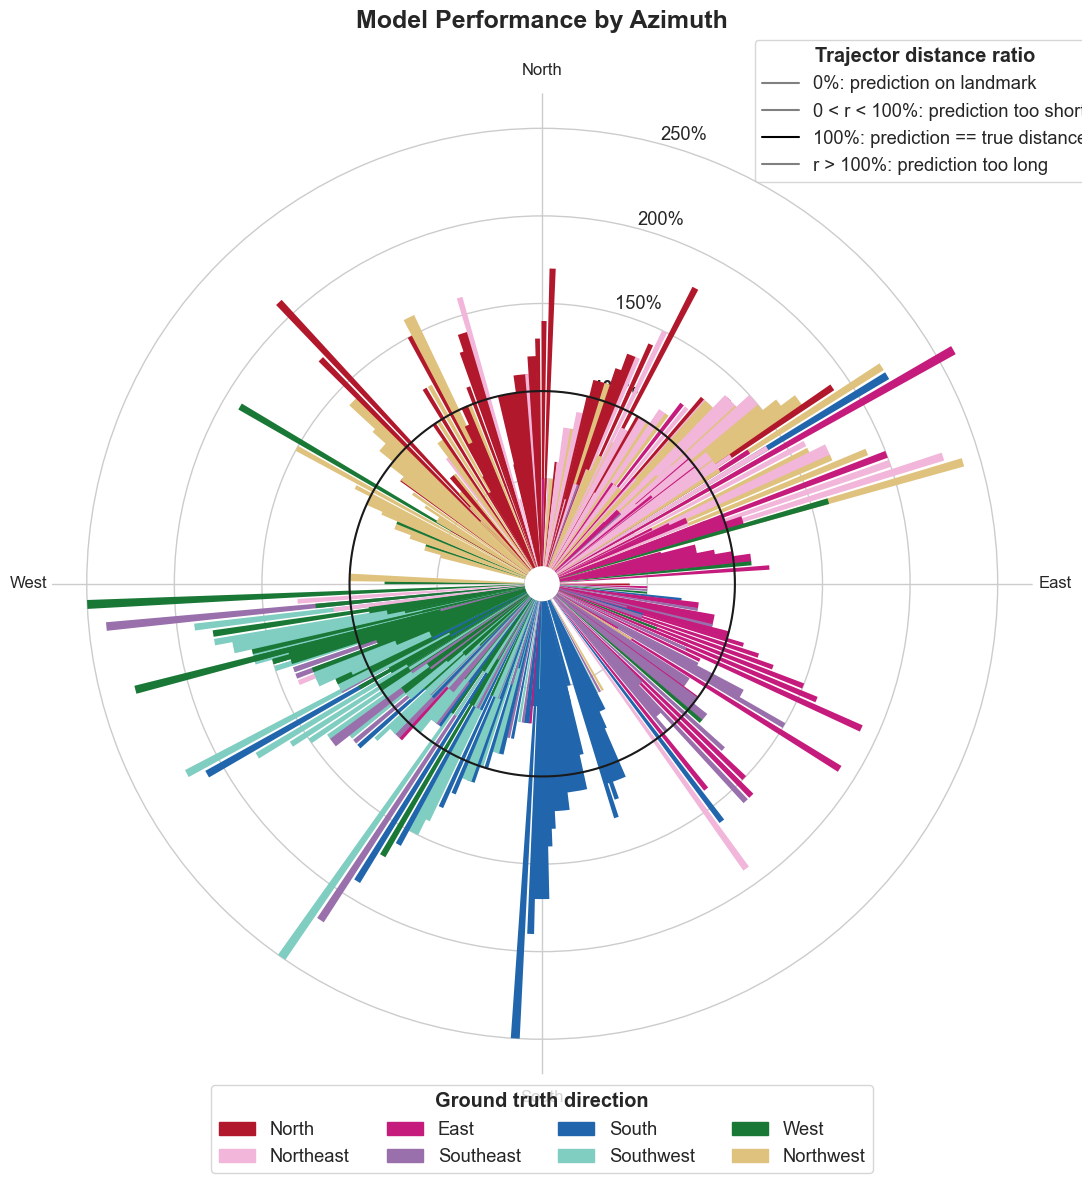

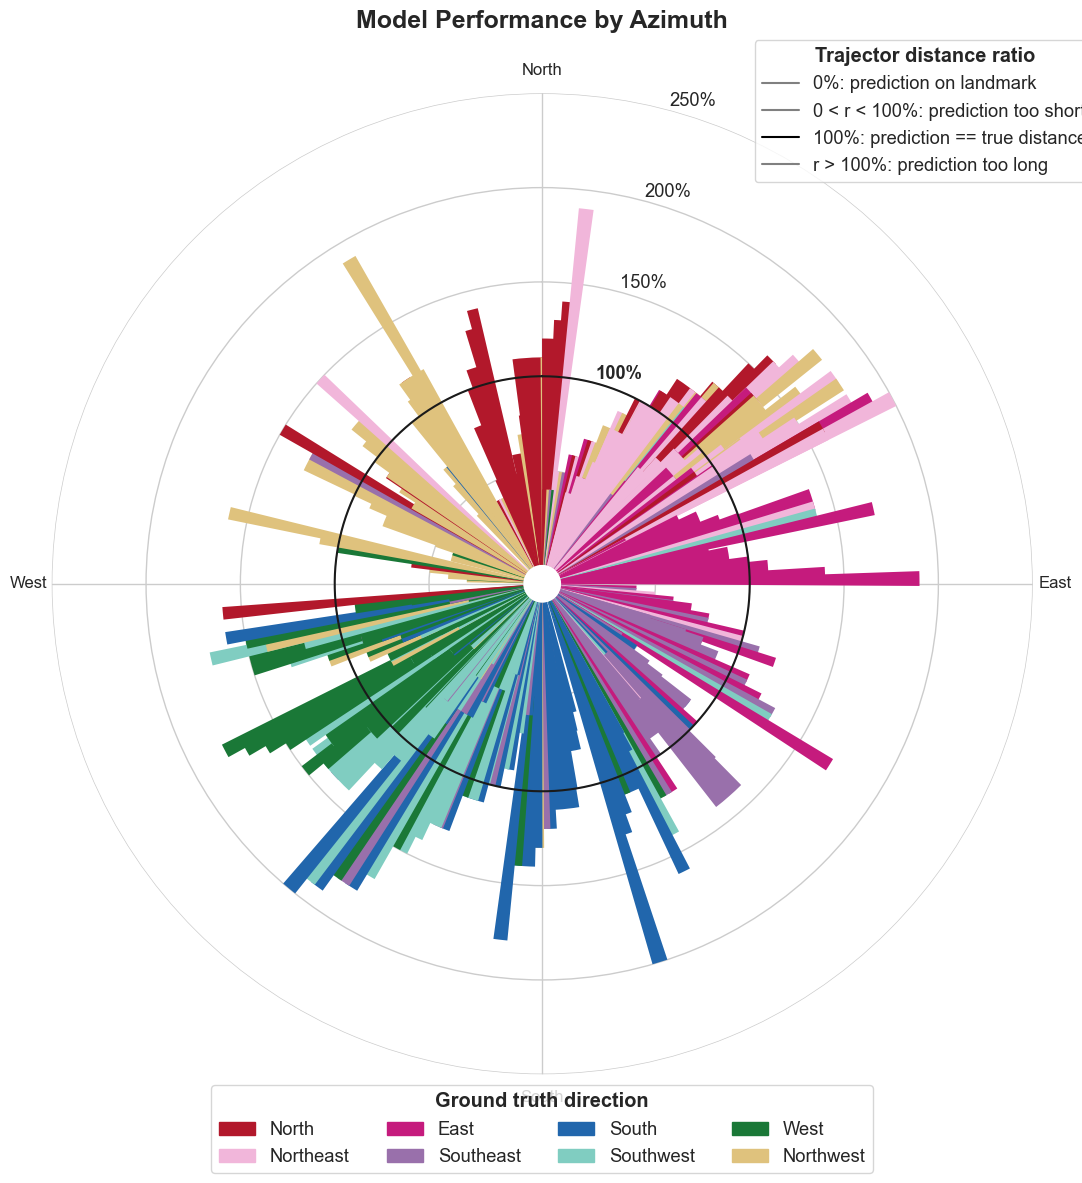

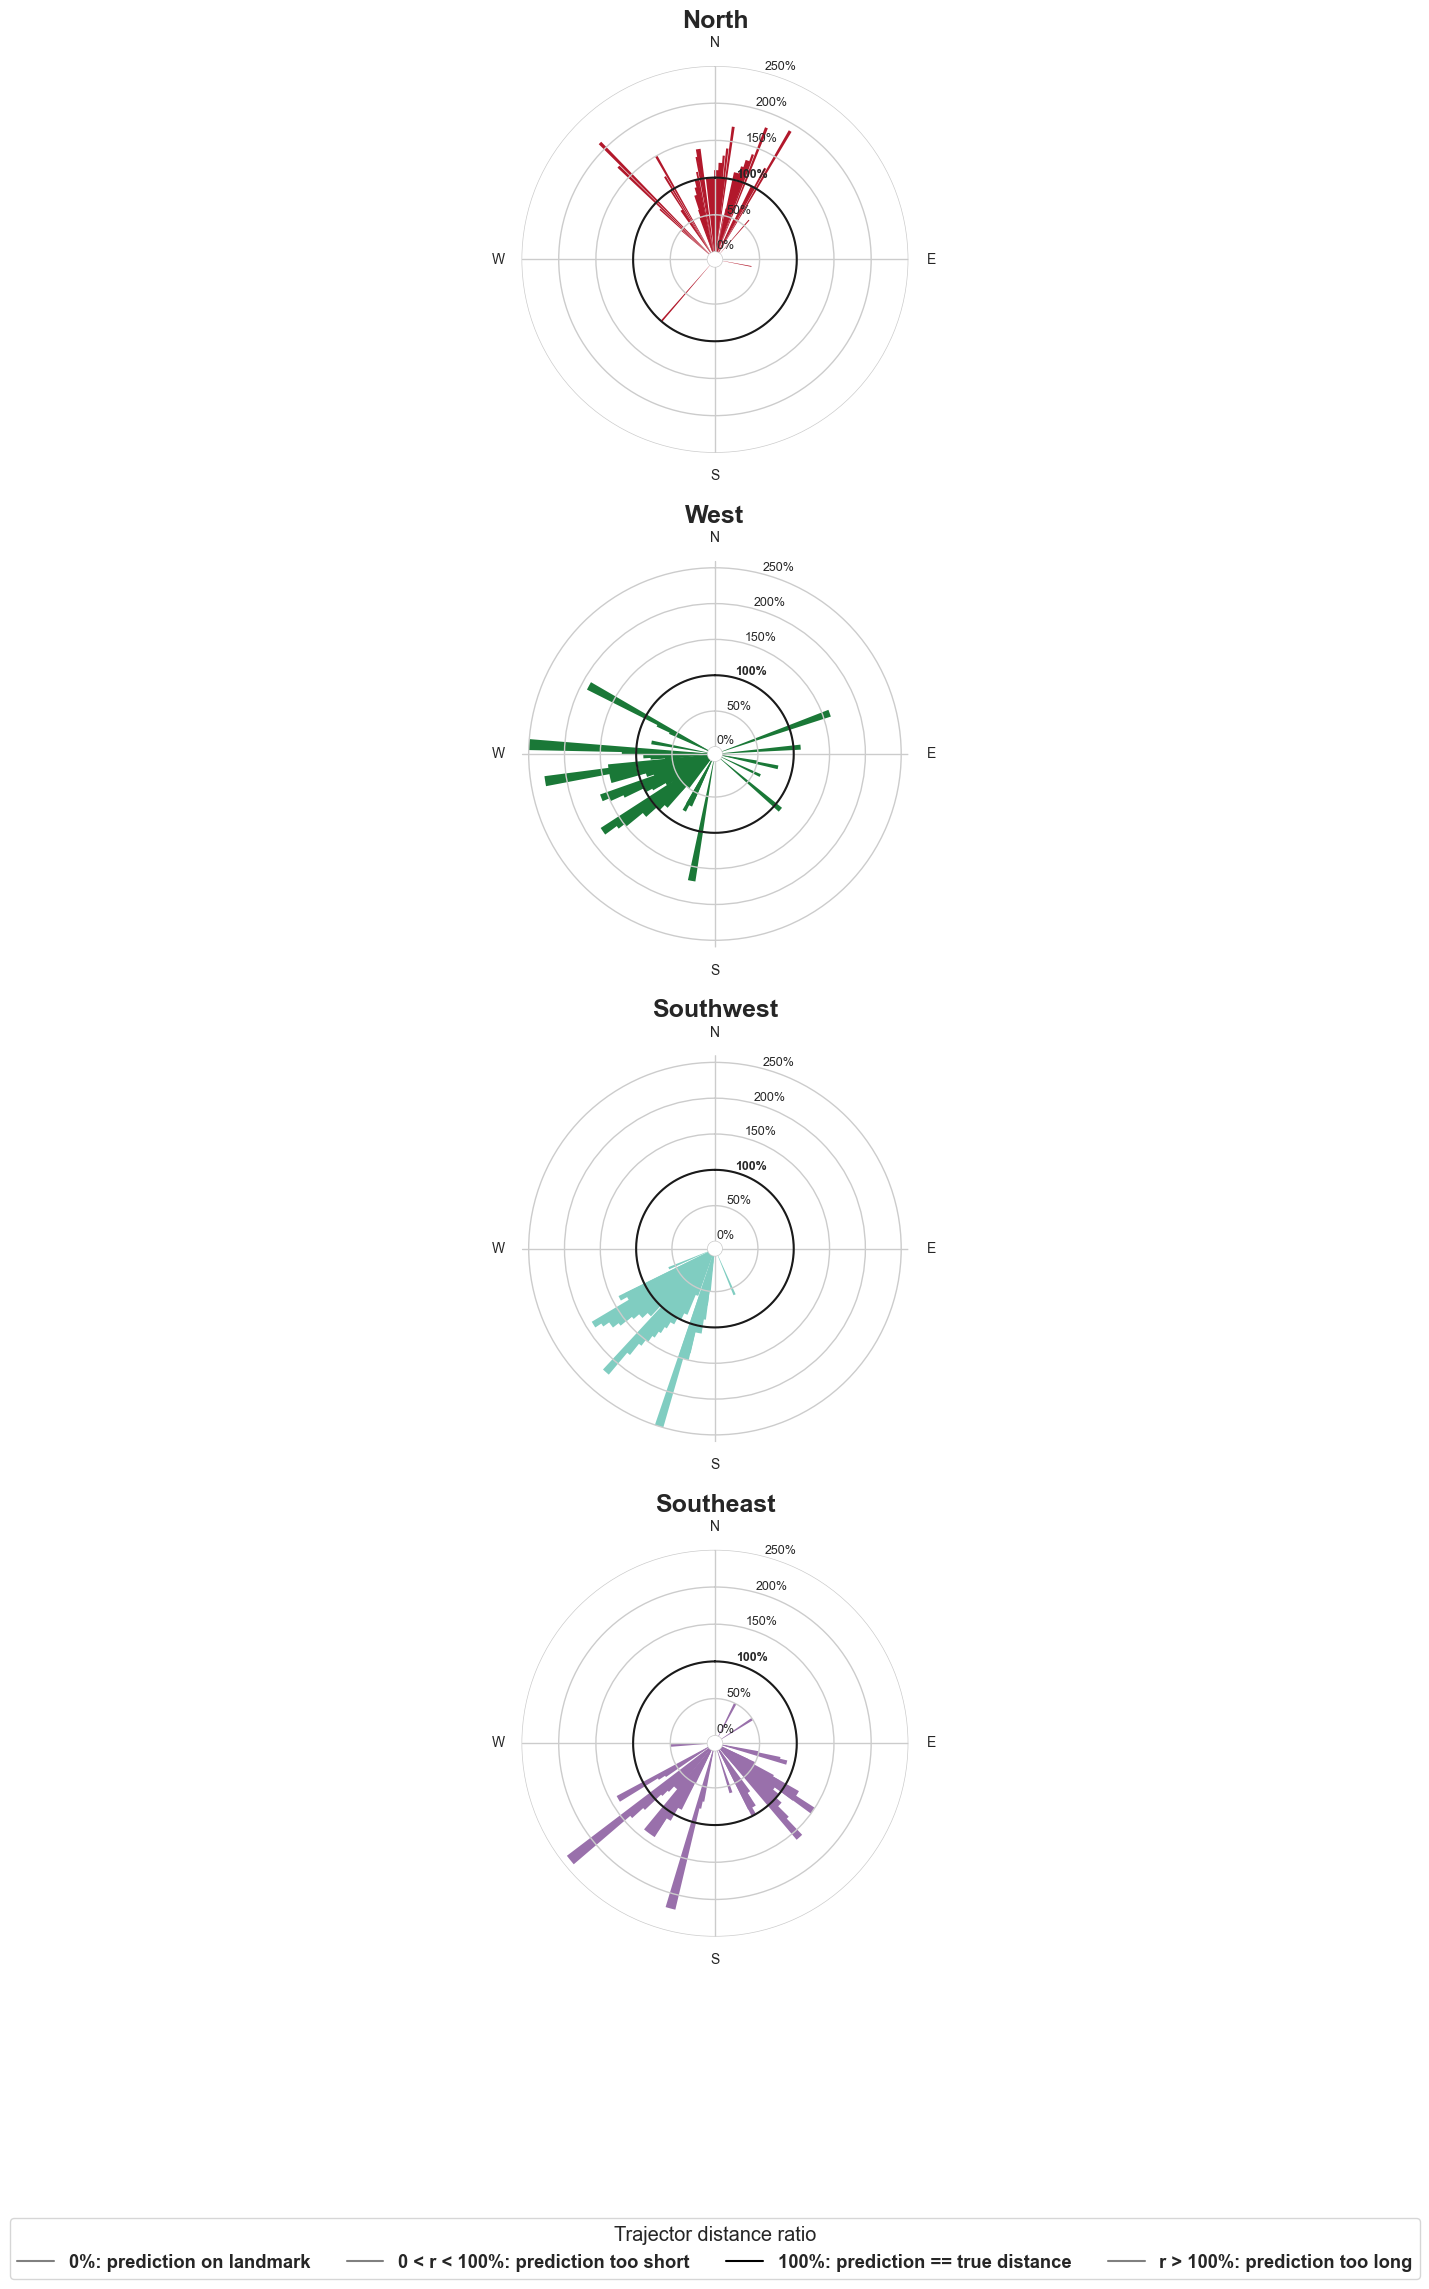

In [12]:
import warnings
warnings.filterwarnings("ignore")

plot_azimuth_visualization(georelated_df_us_llama, plot_type='all_in_one')
plot_azimuth_visualization(georelated_df_eu_llama, plot_type='all_in_one')

plot_azimuth_visualization(georelated_df_us_llama, plot_type='subplots', focus_directions=['north', 'west', 'southwest', 'southeast'], viz_file_name="vertical_focus_directions.png")
# plot_azimuth_visualization(georelated_df_eu_llama, plot_type='subplots', focus_directions=['north', 'west', 'southwest', 'southeast'])

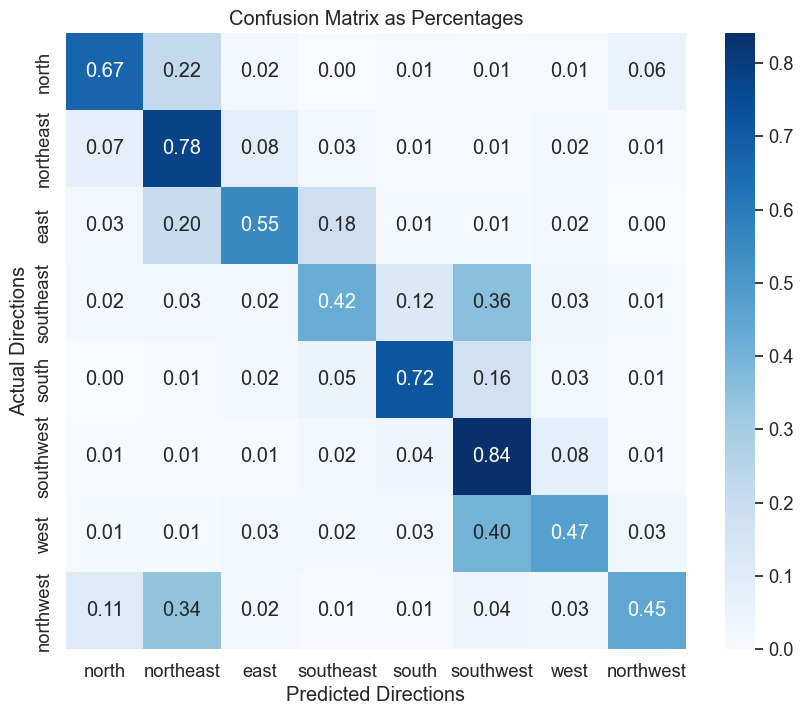

In [13]:
plot_direction_confusion_matrix(
    georelated_df_llama,
    azimuth_col='forward_azimuth',
    gold_col='spatial_relation',
    azimuth_to_direction=azimuth_to_direction,
    compass_dirs=compass_dirs
)

In [139]:
def calculate_between_distance(row):
    if row['between_landmark_2'] is None:
        between_distance = row['distance_to_landmark']
    else:
        between_subj_coords = (row['landmark_latitude'], row['landmark_longitude'])
        between_obj = row['between_landmark_2']
        between_obj_coords = (between_obj['lat'], between_obj['lng'])
        between_distance = geodesic(between_subj_coords, between_obj_coords).meters
    return between_distance

In [155]:
import os
import glob
import re
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import confusion_matrix

# ========== CONFIGURATION ==========
DATA_FOLDER = fr"{repo_root}/output/georelating/"
RESULT_CSV = os.path.join(DATA_FOLDER, "model_region_metrics_summary.csv")
ALL_RUNS_CSV = os.path.join(DATA_FOLDER, "all_run_metrics.csv")

RE_FILENAME = re.compile(
    r"processed_(.+)_(\d+)_(\d+)_cleaned_georelating_dataset_([^_]+)_enriched\.json"
)

VIP_METRICS = [
    ("auc", "auc"),
    ("precision", "average_precision"),
    ("recall", "average_recall"),
    ("f1", "average_f1"),
    ("distance_zeta", "distance_zeta"),
    ("distance_sspb", "distance_sspb"),
    ('fuzzy_cell_match_score', "fuzzy_cell_match_score"),
    ("exact_cell_match_score", "exact_cell_match_score"),
    ('cell_overlap_score', "cell_overlap_score"),
    ('cell_level_accuracy', "cell_level_accuracy"),
    ('cell_level_bias', "cell_level_bias")
]

# ========== DIRECTION CONFUSION MATRIX HANDLING ==========
def run_conf_matrix(df, gold_col='spatial_relation', azimuth_col='forward_azimuth'):
    dir_labels = list(compass_dirs.keys())
    local_df = df.copy()
    local_df['pred_direction'] = local_df[azimuth_col].apply(azimuth_to_direction)
    # Drop NaNs, enforce string
    mask = local_df[gold_col].notna() & local_df['pred_direction'].notna()
    filtered = local_df[mask].copy()
    filtered[gold_col] = filtered[gold_col].astype(str)
    filtered['pred_direction'] = filtered['pred_direction'].astype(str)
    filtered = filtered[
        (filtered[gold_col].str.lower() != 'nan') &
        (filtered['pred_direction'].str.lower() != 'nan')
    ]
    valid_labels = set(compass_dirs.keys())
    filtered = filtered[
        filtered[gold_col].isin(valid_labels) &
        filtered['pred_direction'].isin(valid_labels)
    ]
    matrix = confusion_matrix(filtered[gold_col], filtered['pred_direction'], labels=dir_labels)
    row_sums = matrix.sum(axis=1, keepdims=True)
    # Normalize by row/true label
    percentage = np.divide(matrix, row_sums, out=np.zeros_like(matrix, dtype=float), where=row_sums!=0)
    return percentage, dir_labels

# ========== MAIN SCRIPT ==========
files = glob.glob(os.path.join(DATA_FOLDER, "processed_*_cleaned_georelating_dataset_*_enriched.json"))

all_results = []
per_prep_stats = {}
per_disaster_stats = {}

for f in files:
    filename = os.path.basename(f)
    match = RE_FILENAME.match(filename)
    if not match:
        print(f"Skipping {filename} (pattern mismatch)")
        continue
    model_name, run_number, run_date, region = match.groups()
    try:
        df = pd.read_json(f, orient='records')
    except Exception as ex:
        print(f"Failed to read {filename}: {ex}")
        continue
    df['pred_cell'] = df.apply(safe_latlng_to_cell, axis=1)
    df['pred_cell_area'] = df.apply(lambda x: h3.cell_area(x['pred_cell'], unit="m^2") if x['pred_cell'] else None, axis=1)
    df['cell_relation'] = df.apply(lambda x: get_cell_relation(x['pred_cell'], x['trajector_cell_index']) if x['pred_cell'] and x['trajector_cell_index'] else None, axis=1)
    df[["forward_azimuth", "pred_distance"]] = df.apply(calc_azimuth_distance, axis=1)
    df['distance_to_landmark'] = df.apply(calculate_between_distance, axis=1)

    # ---- Run-level metrics
    run_metrics = calculate_metrics(df, k=10)

    labels = [
        'finer_neighbor', 'parent', 'child', 'coarser_neighbor', 'identical', 'same_resolution_neighbor',
        'disjoint_same_resolution', 'disjoint_coarser_resolution', 'disjoint_finer_resolution'
    ]

    def get_ratios_dict(df):
        # Count occurrences of each cell relation
        cell_relation_counts = df['cell_relation'].value_counts()
        # Ensure order and fill missing labels with 0
        cell_relation_ratios = cell_relation_counts.reindex(labels, fill_value=0) / cell_relation_counts.sum()
        return cell_relation_ratios.to_dict()

    ratios_df = get_ratios_dict(df)

    # ---- Confusion matrix
    cmatrix, dir_labels = run_conf_matrix(df, gold_col='spatial_relation', azimuth_col='forward_azimuth')

    # Collect run-level info for summary
    result_row = dict(
        model_name=model_name,
        run_number=run_number,
        run_date=run_date,
        region=region,
        **run_metrics,
        **ratios_df,
        conf_matrix=cmatrix,
        conf_labels=dir_labels
    )
    all_results.append(result_row)

    # ---- Per-PREPOSITION metrics for this file
    for prep in df["spatial_relation"].dropna().unique():
        subdf = df[df["spatial_relation"] == prep]
        if subdf.empty:
            continue
        prep_metrics = calculate_metrics(subdf, k=10)
        key = (model_name, region, prep)
        if key not in per_prep_stats:
            per_prep_stats[key] = {m[0]: [] for m in VIP_METRICS}
        for (colname, dictkey) in VIP_METRICS:
            per_prep_stats[key][colname].append(prep_metrics[dictkey])

    # ---- Per-DISASTER metrics for this file
    for disaster in df["natural_disaster"].dropna().unique():
        subdf = df[df["natural_disaster"] == disaster]
        if subdf.empty:
            continue
        disaster_metrics = calculate_metrics(subdf, k=10)
        key = (model_name, region, disaster)
        if key not in per_disaster_stats:
            per_disaster_stats[key] = {m[0]: [] for m in VIP_METRICS}
        for (colname, dictkey) in VIP_METRICS:
            per_disaster_stats[key][colname].append(disaster_metrics[dictkey])

# Compile all per-run metrics
all_runs_df = pd.DataFrame(all_results)
all_runs_df.to_csv(ALL_RUNS_CSV, index=False)

# ========== AGGREGATE BY MODEL/REGION ==========
groupcols = ["model_name", "region"]
metriccols = [col for col in all_runs_df.columns if col not in groupcols + ["run_number", "run_date", "conf_matrix", "conf_labels"]]

agg_rows = []
grouped = all_runs_df.groupby(groupcols)
for (model, region), group in grouped:
    agg = {
        "model_name": model,
        "region": region,
        "n_runs": len(group)
    }
    for mcol in metriccols:
        vals = group[mcol].dropna()
        if len(vals) > 1:
            mean = vals.mean()
            ci95 = stats.t.interval(0.95, len(vals)-1, loc=mean, scale=vals.std(ddof=1)/np.sqrt(len(vals)))
            agg[f"{mcol}_mean"] = mean
            agg[f"{mcol}_ci95_lower"] = ci95[0]
            agg[f"{mcol}_ci95_upper"] = ci95[1]
        elif len(vals) == 1:
            agg[f"{mcol}_mean"] = float(vals.iloc[0])
            agg[f"{mcol}_ci95_lower"] = np.nan
            agg[f"{mcol}_ci95_upper"] = np.nan
        else:
            agg[f"{mcol}_mean"] = np.nan
            agg[f"{mcol}_ci95_lower"] = np.nan
            agg[f"{mcol}_ci95_upper"] = np.nan
    agg_rows.append(agg)

# Aggregate metrics across all regions for each model
agg_over_regions = all_runs_df.drop("region", axis=1).groupby("model_name")
for model, group in agg_over_regions:
    agg = {
        "model_name": model,
        "region": "US_and_EU",
        "n_runs": len(group)
    }
    for mcol in metriccols:
        vals = group[mcol].dropna()
        if len(vals) > 1:
            mean = vals.mean()
            ci95 = stats.t.interval(0.95, len(vals)-1, loc=mean, scale=vals.std(ddof=1)/np.sqrt(len(vals)))
            agg[f"{mcol}_mean"] = mean
            agg[f"{mcol}_ci95_lower"] = ci95[0]
            agg[f"{mcol}_ci95_upper"] = ci95[1]
        elif len(vals) == 1:
            agg[f"{mcol}_mean"] = float(vals.iloc[0])
            agg[f"{mcol}_ci95_lower"] = np.nan
            agg[f"{mcol}_ci95_upper"] = np.nan
        else:
            agg[f"{mcol}_mean"] = np.nan
            agg[f"{mcol}_ci95_lower"] = np.nan
            agg[f"{mcol}_ci95_upper"] = np.nan
    agg_rows.append(agg)

agg_df = pd.DataFrame(agg_rows)

# ========== AGGREGATE PER-PREPOSITION METRICS ==========
colstubs = []
for idx, row in agg_df.iterrows():
    model = row["model_name"]
    region = row["region"]
    for (m, r, prep), metric_dict in per_prep_stats.items():
        if m == model and (r == region):
            for colname, _ in VIP_METRICS:
                values = np.array(metric_dict[colname])
                values = values[~np.isnan(values)]
                colstub = f"{prep}_{colname}"
                colstubs.extend([f"{colstub}_mean", f"{colstub}_ci95_upper", f"{colstub}_ci95_lower"])
                if len(values) > 1:
                    mean = values.mean()
                    ci95 = stats.t.interval(0.95, len(values)-1, loc=mean, scale=values.std(ddof=1)/np.sqrt(len(values)))
                elif len(values) == 1:
                    mean = float(values[0])
                    ci95 = (np.nan, np.nan)
                else:
                    mean = np.nan
                    ci95 = (np.nan, np.nan)
                agg_df.at[idx, f"{colstub}_mean"] = mean
                agg_df.at[idx, f"{colstub}_ci95_lower"] = ci95[0]
                agg_df.at[idx, f"{colstub}_ci95_upper"] = ci95[1]
for idx, row in agg_df.iterrows():
    model = row["model_name"]
    region = row["region"]
    if region != "US_and_EU":
        continue
    # iterate over the columns in agg_df
    for series_name, series in agg_df.items():
        if series_name in set(colstubs):
            regional_values = agg_df[series_name].loc[agg_df['model_name'] == model]
            agg_df.at[idx, series_name] = regional_values.mean()


# ========== AGGREGATE PER-DISASTER METRICS ==========
for idx, row in agg_df.iterrows():
    model = row["model_name"]
    region = row["region"]
    for (m, r, disaster), metric_dict in per_disaster_stats.items():
        if m == model and (r == region or region == "US_and_EU"):
            for colname, _ in VIP_METRICS:
                values = np.array(metric_dict[colname])
                values = values[~np.isnan(values)]
                colstub = f"{disaster}_{colname}"
                colstubs.extend([f"{colstub}_mean", f"{colstub}_ci95_upper", f"{colstub}_ci95_lower"])
                if len(values) > 1:
                    mean = values.mean()
                    ci95 = stats.t.interval(0.95, len(values)-1, loc=mean, scale=values.std(ddof=1)/np.sqrt(len(values)))
                elif len(values) == 1:
                    mean = float(values[0])
                    ci95 = (np.nan, np.nan)
                else:
                    mean = np.nan
                    ci95 = (np.nan, np.nan)
                agg_df.at[idx, f"{colstub}_mean"] = mean
                agg_df.at[idx, f"{colstub}_ci95_lower"] = ci95[0]
                agg_df.at[idx, f"{colstub}_ci95_upper"] = ci95[1]
for idx, row in agg_df.iterrows():
    model = row["model_name"]
    region = row["region"]
    if region != "US_and_EU":
        continue
    # iterate over the columns in agg_df
    for series_name, series in agg_df.items():
        if series_name in set(colstubs):
            regional_values = agg_df[series_name].loc[agg_df['model_name'] == model]
            agg_df.at[idx, series_name] = regional_values.mean()
# ========== AGGREGATE CONFUSION MATRICES ==========
conf_by_group = {}
for (model, region), group in all_runs_df.groupby(["model_name", "region"]):
    conf_matrices = [row["conf_matrix"] for _, row in group.iterrows() if "conf_matrix" in row and row["conf_matrix"] is not None]
    if conf_matrices:
        conf_by_group[(model, region)] = np.stack(conf_matrices, axis=0)  # shape: (R, L, L)

for idx, row in agg_df.iterrows():
    model = row["model_name"]
    region = row["region"]
    if (model, region) not in conf_by_group:
        continue
    mats = conf_by_group[(model, region)]  # shape (R, L, L)
    n_runs, L, _ = mats.shape
    # Use the common compass label order (should be identical across runs)
    dir_labels = all_runs_df[
        (all_runs_df["model_name"] == model) & (all_runs_df["region"] == region)
    ]["conf_labels"].iloc[0]
    for i, gold_dir in enumerate(dir_labels):
        for j, pred_dir in enumerate(dir_labels):
            vals = mats[:, i, j]
            vals = vals[~np.isnan(vals)]
            if len(vals) > 1:
                mean = vals.mean()
            elif len(vals) == 1:
                mean = float(vals[0])
            else:
                mean = np.nan
            col_base = f"conf_{gold_dir}_{pred_dir}"
            agg_df.at[idx, f"{col_base}_mean"] = mean

agg_df.to_csv(RESULT_CSV, index=False)
print("Saved summary to", RESULT_CSV)
print("Saved per-run metrics to", ALL_RUNS_CSV)

Saved summary to /Users/kaimoltzen/academiccloudsync/Uni/Master/5_WS24_25-MA/geoparse-natural-disasters-with-llms/output/georelating/model_region_metrics_summary.csv
Saved per-run metrics to /Users/kaimoltzen/academiccloudsync/Uni/Master/5_WS24_25-MA/geoparse-natural-disasters-with-llms/output/georelating/all_run_metrics.csv


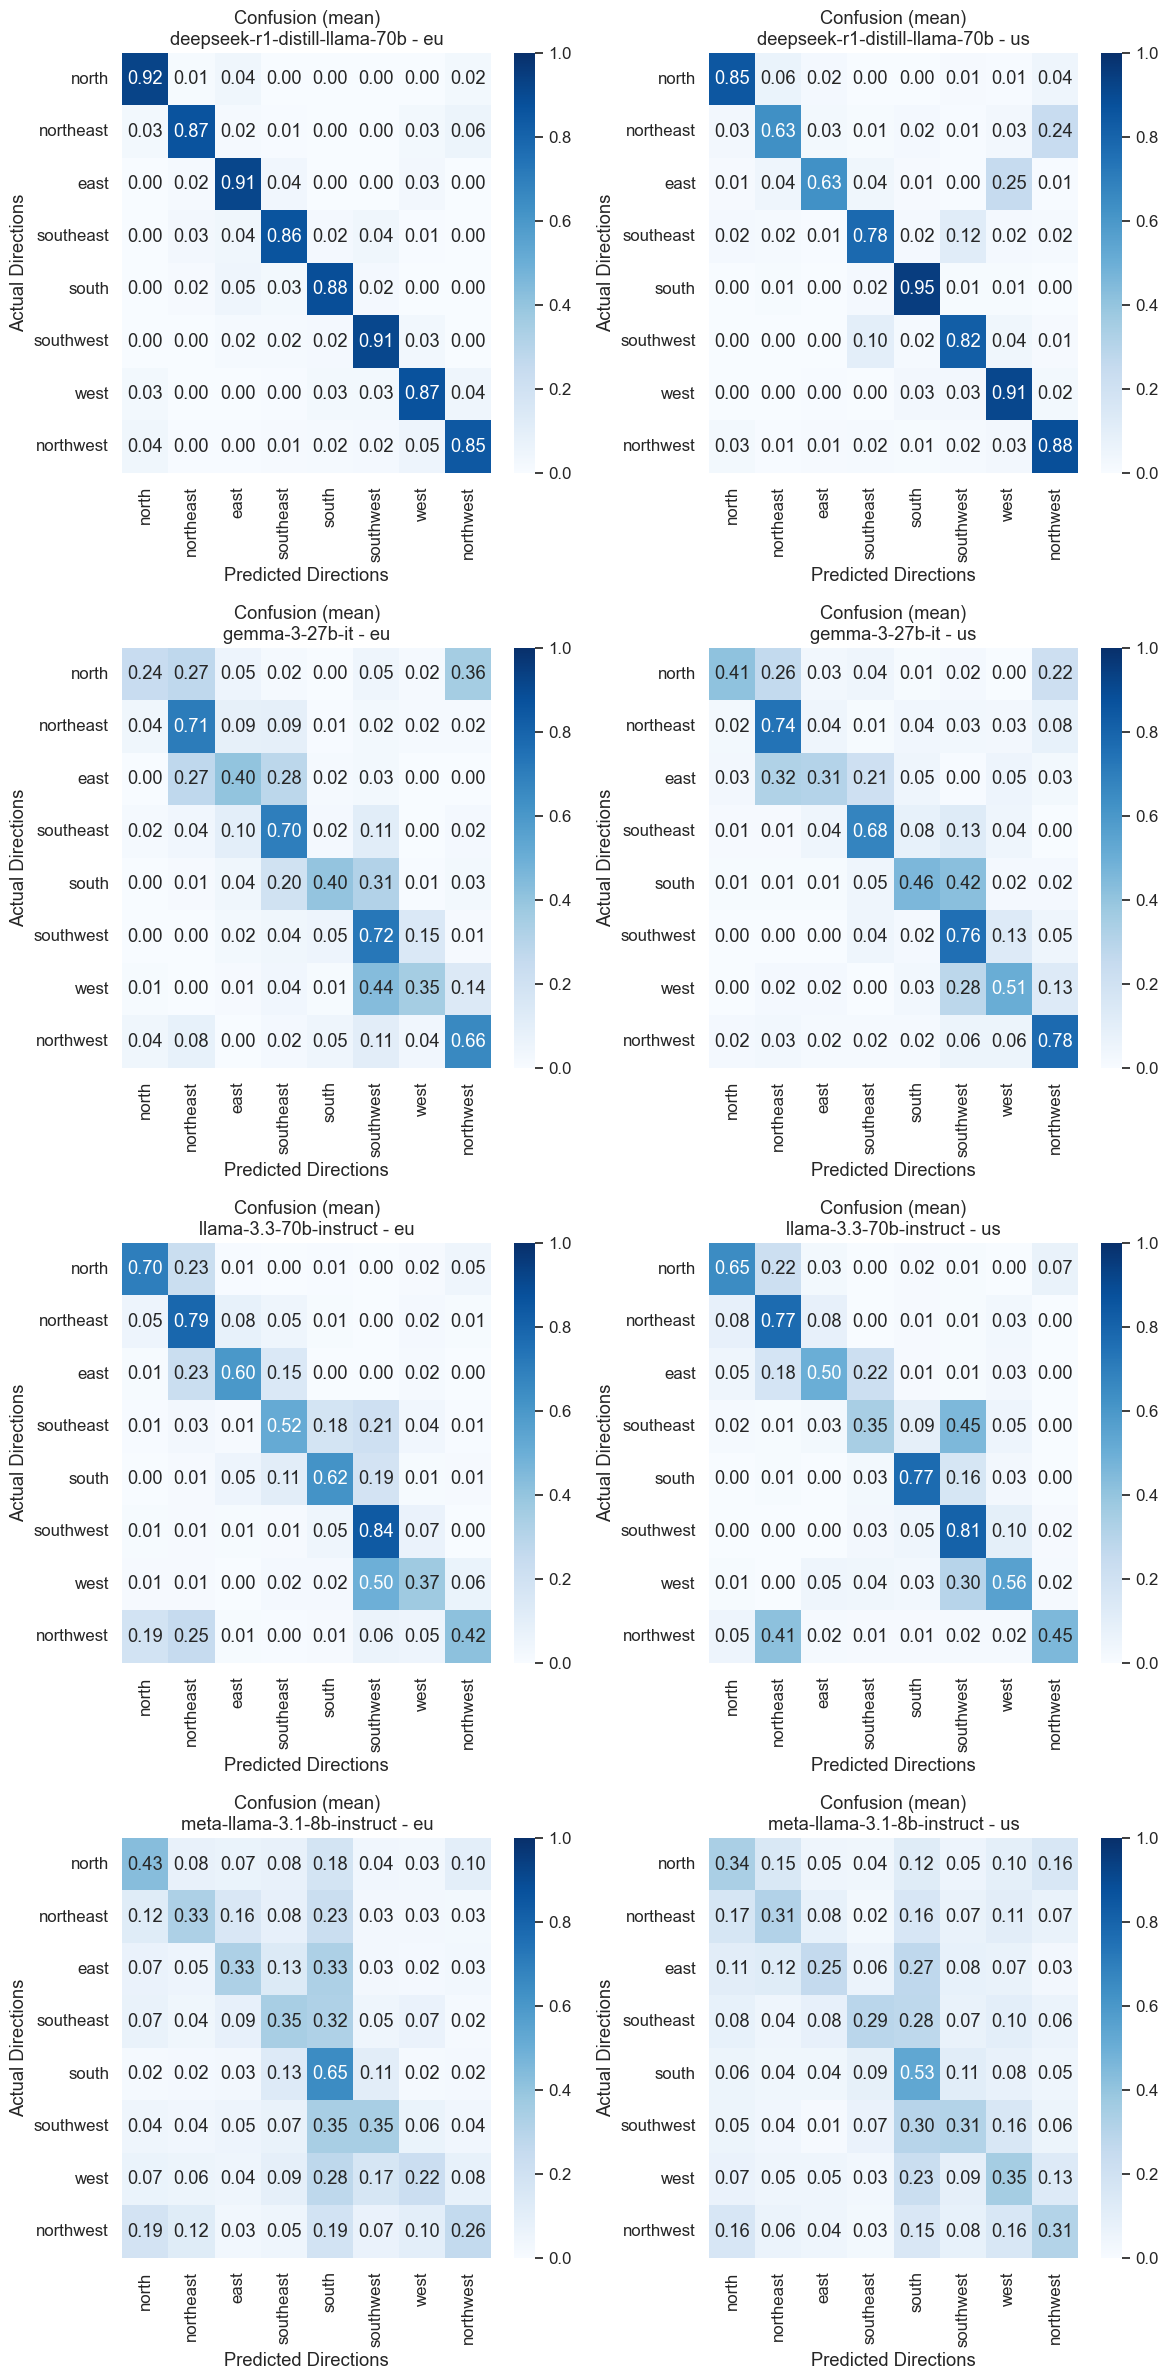

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# The label order (should be the same as used in the confusion matrices)
dir_labels = list(compass_dirs.keys())
L = len(dir_labels)

# Get all model-region pairs except for the aggregated ones
model_region_pairs = list(agg_df[["model_name", "region"]].itertuples(index=False, name=None))
model_region_pairs = [(m, r) for m, r in model_region_pairs if r != "US_and_EU"]
n_plot = len(model_region_pairs)

# Decide subplot grid
ncol = min(n_plot, 2)
nrow = (n_plot + ncol - 1) // ncol

fig, axes = plt.subplots(nrow, ncol, figsize=(6 * ncol, 6 * nrow), squeeze=False)

for idx, (model, region) in enumerate(model_region_pairs):
    row_pos, col_pos = divmod(idx, ncol)
    ax = axes[row_pos, col_pos]

    # Build mean confusion matrix for this group
    conf_mean = np.zeros((L, L))
    subrow = agg_df.query("model_name == @model and region == @region").iloc[0]
    for i, true_lab in enumerate(dir_labels):
        for j, pred_lab in enumerate(dir_labels):
            colname = f"conf_{true_lab}_{pred_lab}_mean"
            conf_mean[i, j] = subrow.get(colname, np.nan)

    sns.heatmap(conf_mean, annot=True, cmap='Blues', fmt='.2f',
                xticklabels=dir_labels, yticklabels=dir_labels, ax=ax,
                vmin=0, vmax=1)

    ax.set_xlabel('Predicted Directions')
    ax.set_ylabel('Actual Directions')
    ax.set_title(f'Confusion (mean)\n{model} - {region}')

# Hide unused axes
for idx in range(n_plot, nrow*ncol):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

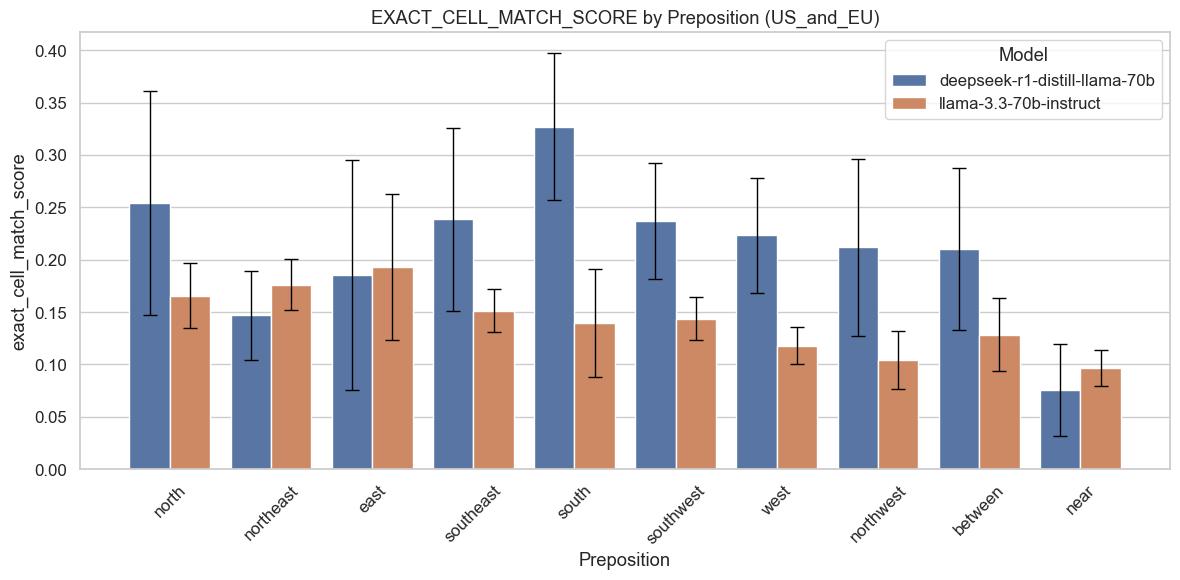

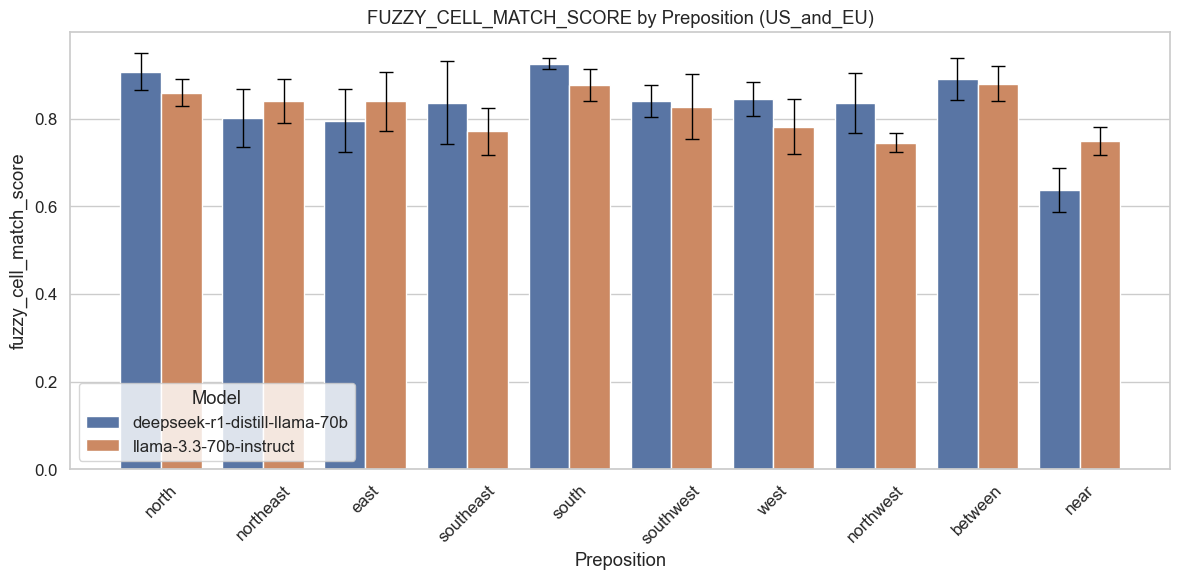

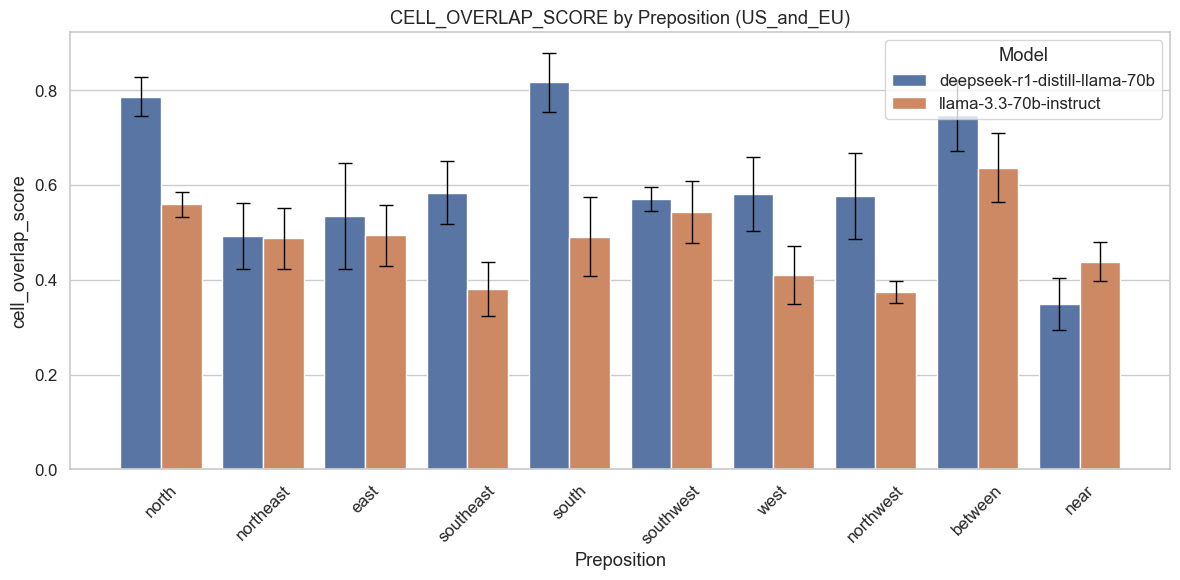

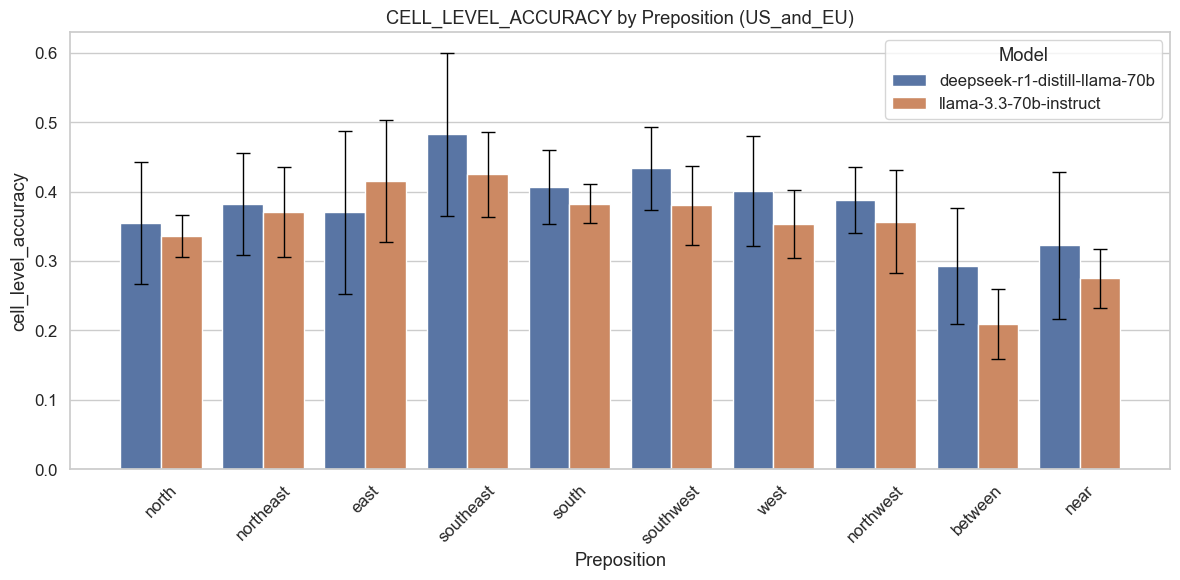

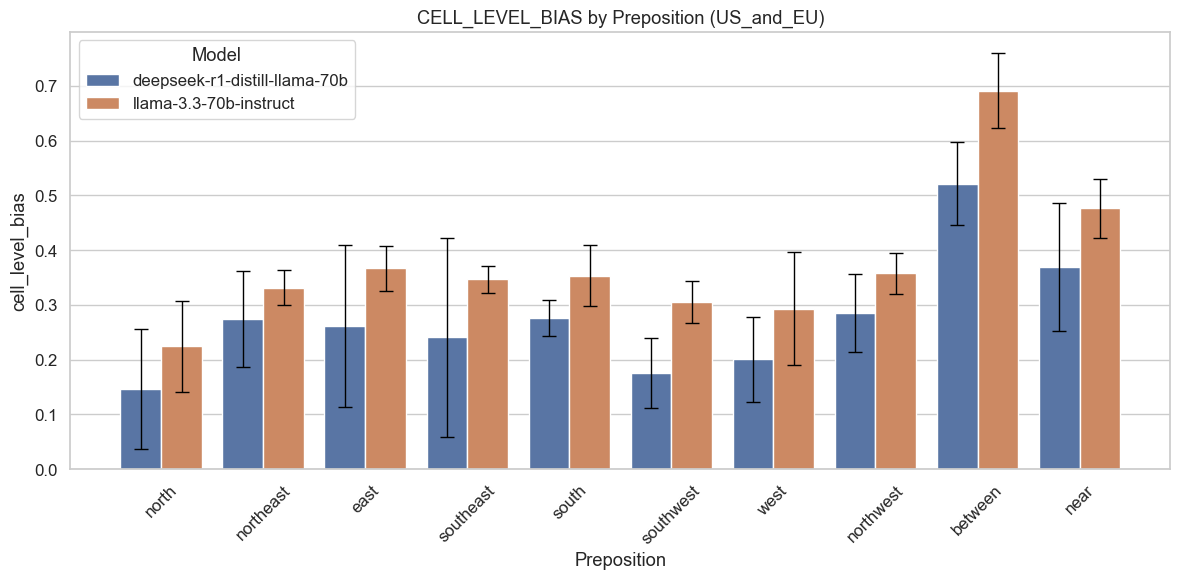

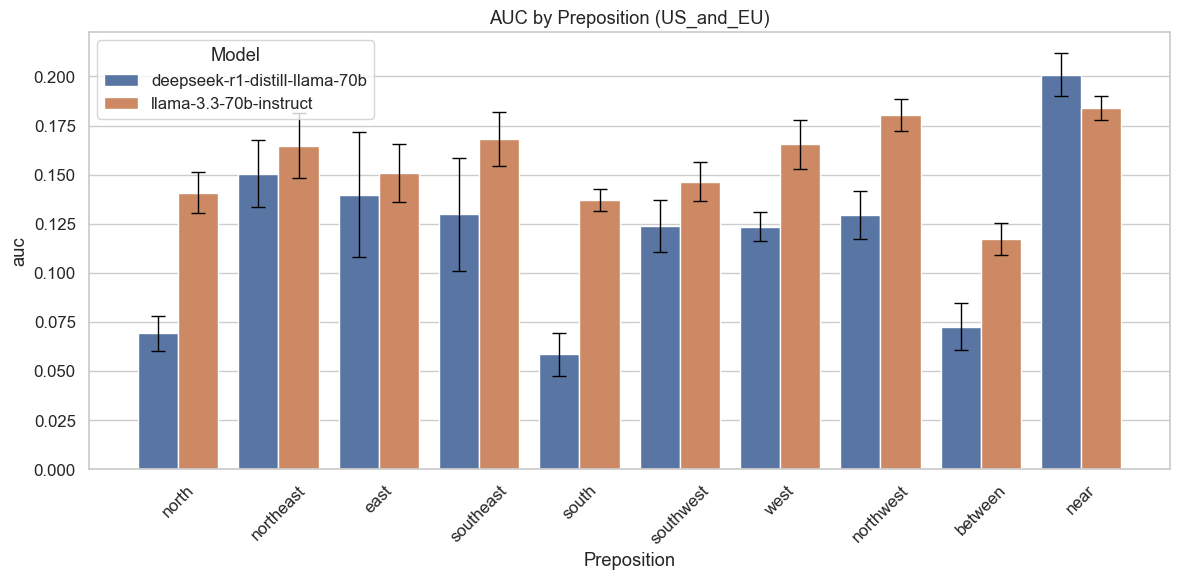

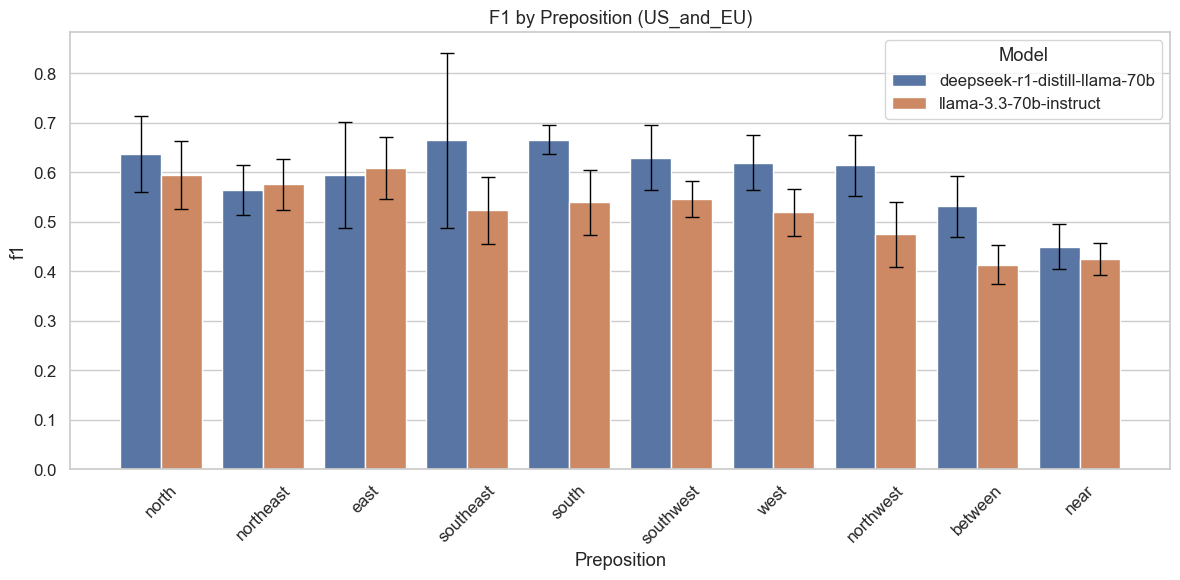

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

region_name = "US_and_EU"

models = ["deepseek-r1-distill-llama-70b", "llama-3.3-70b-instruct"]
region_df = agg_df[(agg_df["region"] == region_name) & (agg_df["model_name"].isin(models))]

# Metrics and geospatial prepositions
metrics = ["exact_cell_match_score", "fuzzy_cell_match_score", "cell_overlap_score", "cell_level_accuracy", "cell_level_bias", "auc", "f1"]
prepositions = [
    "north", "northeast", "east", "southeast", "south",
    "southwest", "west", "northwest", "between", "near"
]

# Collect relevant data
data = []
for metric in metrics:
    for prep in prepositions:
        mean_col = f"{prep}_{metric}_mean"
        lower_col = f"{prep}_{metric}_ci95_lower"
        upper_col = f"{prep}_{metric}_ci95_upper"
        if mean_col in region_df.columns:
            for _, row in region_df.iterrows():
                data.append({
                    "model": row["model_name"],
                    "preposition": prep,
                    "metric": metric,
                    "mean": row[mean_col],
                    "upper_error": row[upper_col] - row[mean_col],
                    "lower_error": row[mean_col] - row[lower_col]
                })

# Create DataFrame
viz_df_preps = pd.DataFrame(data)

# Plotting
sns.set_theme(style="whitegrid", font_scale=1.1)

for metric in metrics:
    plt.figure(figsize=(12, 6))
    metric_data = viz_df_preps[viz_df_preps["metric"] == metric]

    # Create barplot and store bar positions
    ax = sns.barplot(
        data=metric_data,
        x="preposition",
        y="mean",
        hue="model",
        ci=None,
        capsize=0.05,
        dodge=True,
        errwidth=0  # suppress auto error bars
    )

    # Get x-tick locations for each group
    xticks = ax.get_xticks()
    n_models = len(models)
    bar_width = 0.8 / n_models  # default bar width logic for dodge=True

    # Add error bars manually
    for i, (index, row) in enumerate(metric_data.iterrows()):
        prep_index = prepositions.index(row["preposition"])
        model_index = models.index(row["model"])
        x = xticks[prep_index] - 0.4 + (model_index + 0.5) * bar_width
        ax.errorbar(x, row["mean"], yerr=np.array([[row["lower_error"]], [row["upper_error"]]]), fmt='none',
                    ecolor='black', capsize=5, linewidth=1)

    plt.title(f"{metric.upper()} by Preposition ({region_name})")
    plt.ylabel(metric)
    plt.xlabel("Preposition")
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

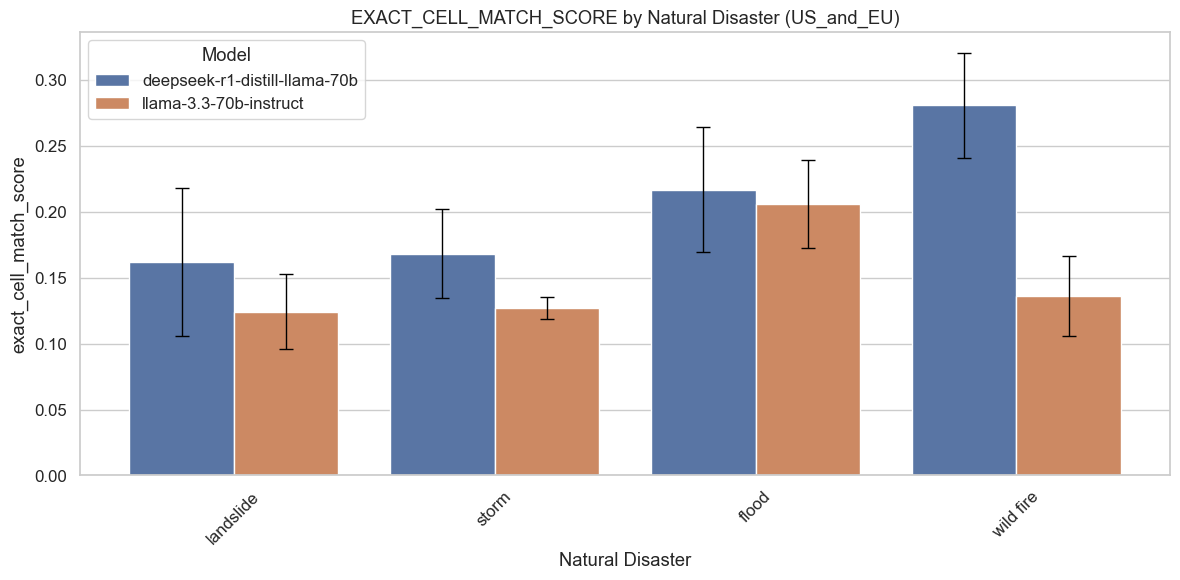

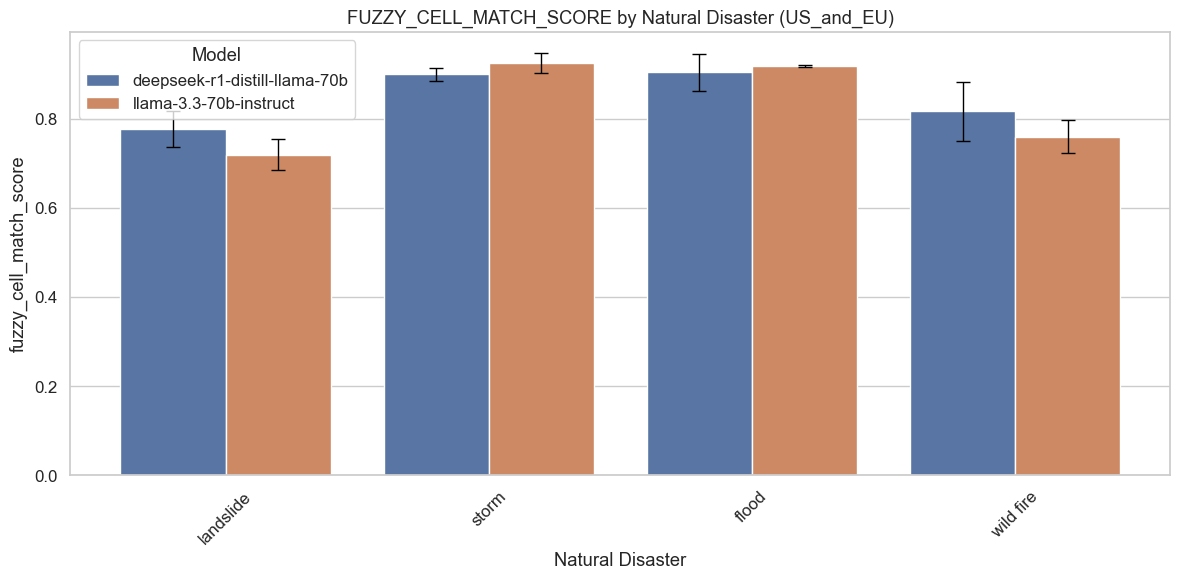

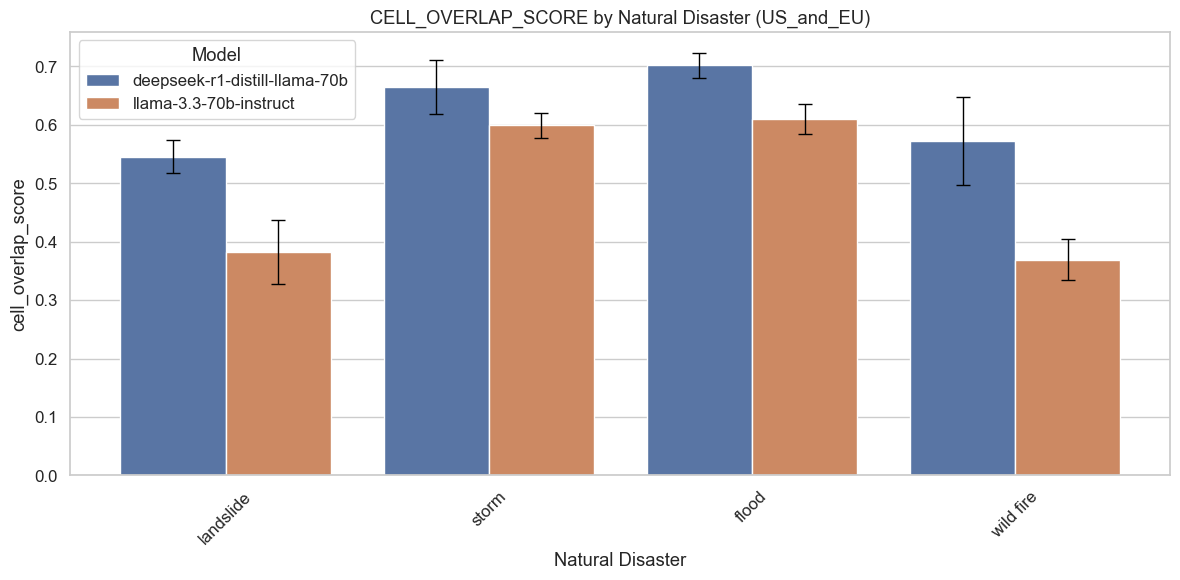

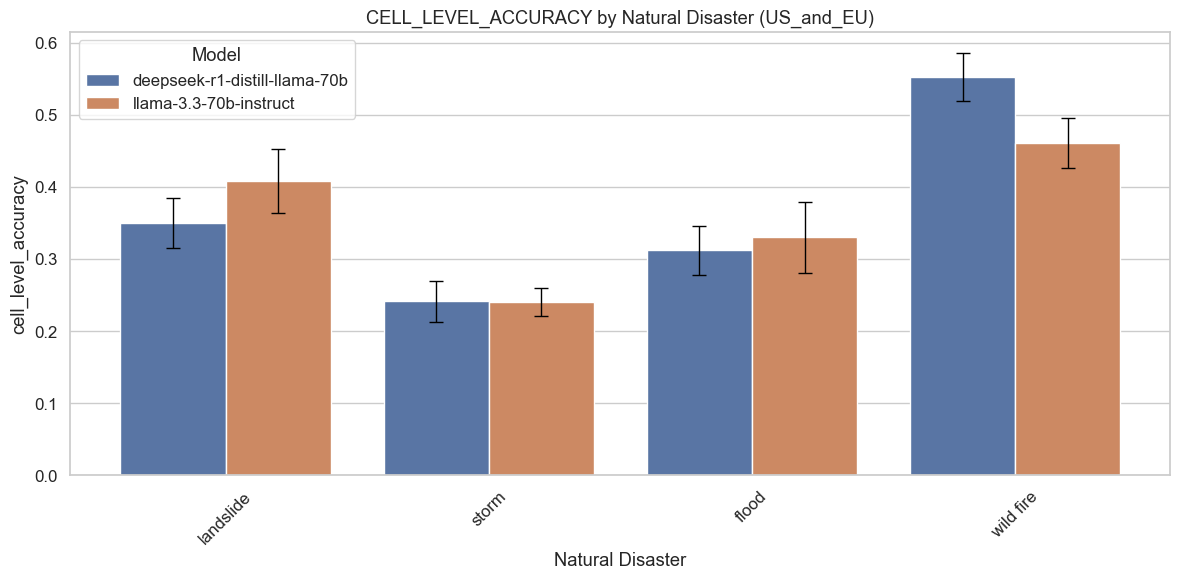

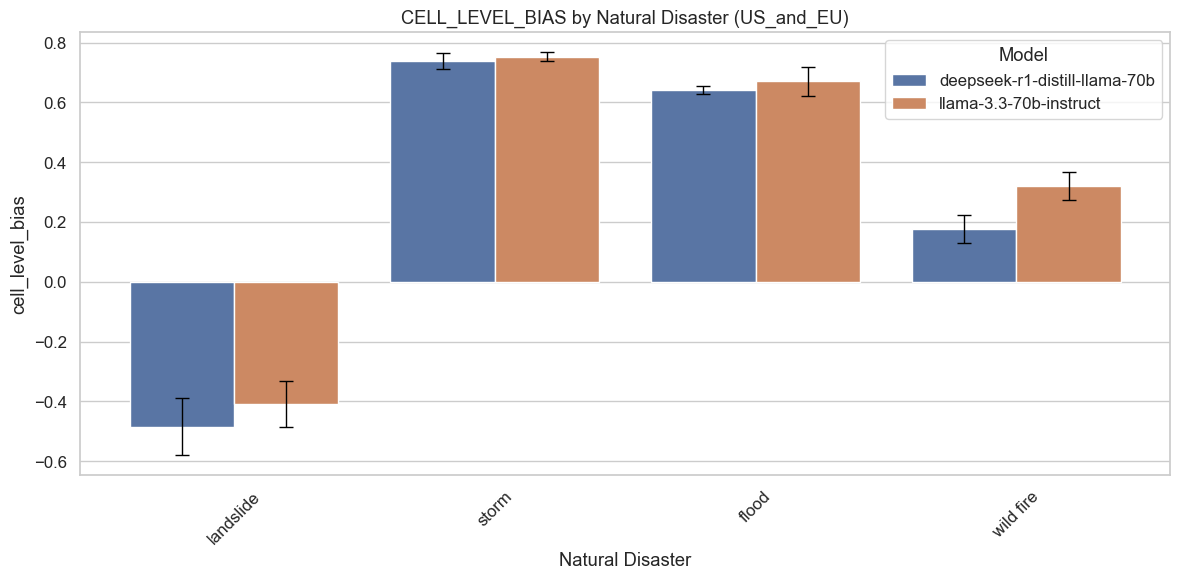

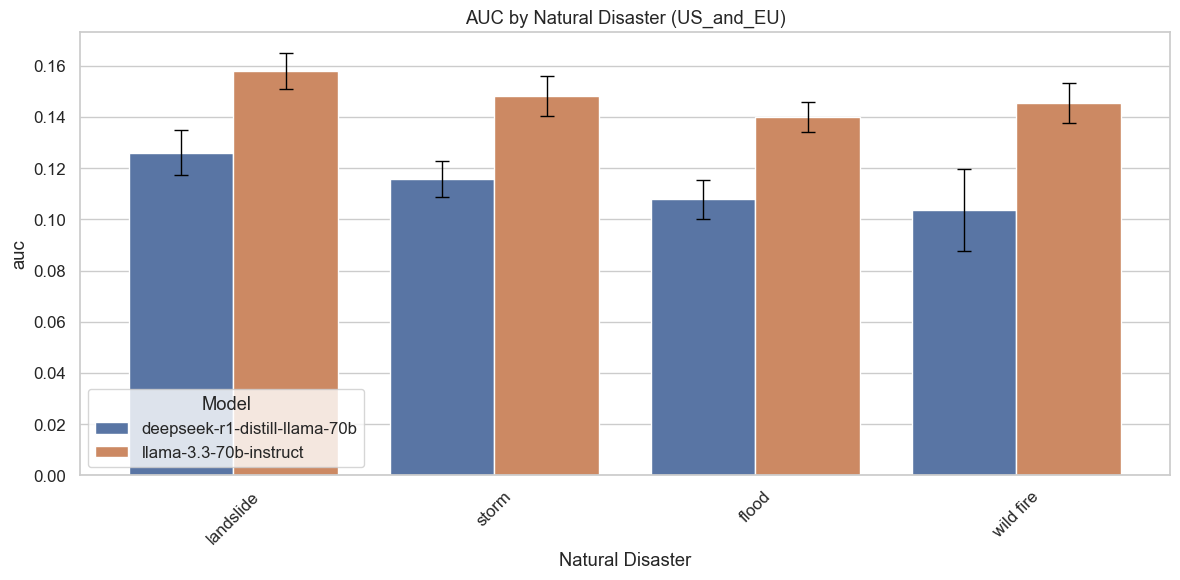

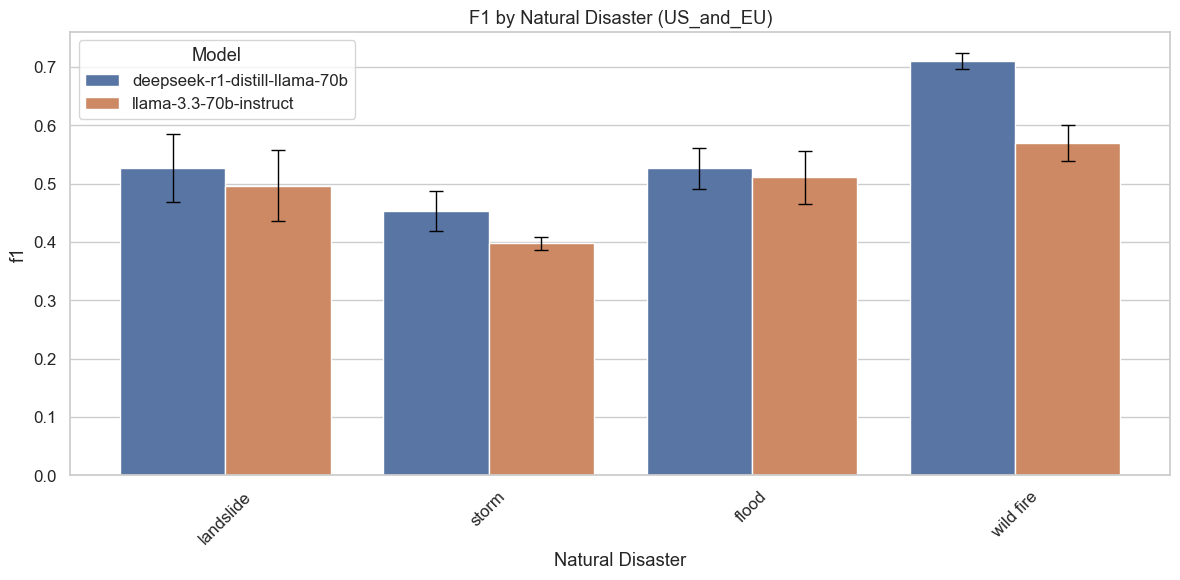

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

region_name = "US_and_EU"

models = ["deepseek-r1-distill-llama-70b", "llama-3.3-70b-instruct"]
region_df = agg_df[(agg_df["region"] == region_name) & (agg_df["model_name"].isin(models))]

# Metrics and natural disasters
metrics = ["exact_cell_match_score", "fuzzy_cell_match_score", "cell_overlap_score", "cell_level_accuracy", "cell_level_bias", "auc", "f1"]
natural_disasters = list(df["natural_disaster"].dropna().unique())

# Collect relevant data
data = []
for metric in metrics:
    for dis in natural_disasters:
        mean_col = f"{dis}_{metric}_mean"
        lower_col = f"{dis}_{metric}_ci95_lower"
        upper_col = f"{dis}_{metric}_ci95_upper"
        if mean_col in region_df.columns:
            for _, row in region_df.iterrows():
                data.append({
                    "model": row["model_name"],
                    "disaster": dis,
                    "metric": metric,
                    "mean": row[mean_col],
                    "upper_error": row[upper_col] - row[mean_col],
                    "lower_error": row[mean_col] - row[lower_col]
                })

# Create DataFrame
viz_df_dis = pd.DataFrame(data)

# Plotting
sns.set_theme(style="whitegrid", font_scale=1.1)

for metric in metrics:
    plt.figure(figsize=(12, 6))
    metric_data = viz_df_dis[viz_df_dis["metric"] == metric]

    # Create barplot and store bar positions
    ax = sns.barplot(
        data=metric_data,
        x="disaster",
        y="mean",
        hue="model",
        ci=None,
        capsize=0.05,
        dodge=True,
        errwidth=0  # suppress auto error bars
    )

    # Get x-tick locations for each group
    xticks = ax.get_xticks()
    n_models = len(models)
    bar_width = 0.8 / n_models  # default bar width logic for dodge=True

    # Add error bars manually
    for i, (index, row) in enumerate(metric_data.iterrows()):
        dis_index = natural_disasters.index(row["disaster"])
        model_index = models.index(row["model"])
        x = xticks[dis_index] - 0.4 + (model_index + 0.5) * bar_width
        ax.errorbar(x, row["mean"], yerr=np.array([[row["lower_error"]], [row["upper_error"]]]), fmt='none',
                    ecolor='black', capsize=5, linewidth=1)

    plt.title(f"{metric.upper()} by Natural Disaster ({region_name})")
    plt.ylabel(metric)
    plt.xlabel("Natural Disaster")
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

In [160]:
for index, row in agg_df.iterrows():
    cell_level_accuracy = row['identical_mean'] + row['disjoint_same_resolution_mean'] + row['same_resolution_neighbor_mean']
    print(f"{row['model_name']} on {row['region']} data: {cell_level_accuracy:3f} cell level accuracy")

deepseek-r1-distill-llama-70b on eu data: 0.322691 cell level accuracy
deepseek-r1-distill-llama-70b on us data: 0.440029 cell level accuracy
gemma-3-27b-it on eu data: 0.330059 cell level accuracy
gemma-3-27b-it on us data: 0.454545 cell level accuracy
llama-3.3-70b-instruct on eu data: 0.379557 cell level accuracy
llama-3.3-70b-instruct on us data: 0.313920 cell level accuracy
meta-llama-3.1-8b-instruct on eu data: 0.373989 cell level accuracy
meta-llama-3.1-8b-instruct on us data: 0.313170 cell level accuracy
deepseek-r1-distill-llama-70b on US_and_EU data: 0.381360 cell level accuracy
gemma-3-27b-it on US_and_EU data: 0.392302 cell level accuracy
llama-3.3-70b-instruct on US_and_EU data: 0.346738 cell level accuracy
meta-llama-3.1-8b-instruct on US_and_EU data: 0.343580 cell level accuracy


In [161]:
for index, row in agg_df.iterrows():
    fuzzy_cell_match_score = 1 - (row['disjoint_same_resolution_mean'] + row['disjoint_coarser_resolution_mean'] + row['disjoint_finer_resolution_mean'])
    cell_overlap_score = row['parent_mean'] + row['identical_mean'] + row['child_mean']
    print(f"{row['model_name']} on {row['region']} data: {fuzzy_cell_match_score:3f} fuzzy cell match score, {cell_overlap_score:3f} cell overlap score")

deepseek-r1-distill-llama-70b on eu data: 0.887861 fuzzy cell match score, 0.657057 cell overlap score
deepseek-r1-distill-llama-70b on us data: 0.777515 fuzzy cell match score, 0.555484 cell overlap score
gemma-3-27b-it on eu data: 0.847410 fuzzy cell match score, 0.513065 cell overlap score
gemma-3-27b-it on us data: 0.699588 fuzzy cell match score, 0.387579 cell overlap score
llama-3.3-70b-instruct on eu data: 0.864202 fuzzy cell match score, 0.514105 cell overlap score
llama-3.3-70b-instruct on us data: 0.771980 fuzzy cell match score, 0.454226 cell overlap score
meta-llama-3.1-8b-instruct on eu data: 0.803963 fuzzy cell match score, 0.410592 cell overlap score
meta-llama-3.1-8b-instruct on us data: 0.692539 fuzzy cell match score, 0.299944 cell overlap score
deepseek-r1-distill-llama-70b on US_and_EU data: 0.832688 fuzzy cell match score, 0.606270 cell overlap score
gemma-3-27b-it on US_and_EU data: 0.773499 fuzzy cell match score, 0.450322 cell overlap score
llama-3.3-70b-instruc

In [216]:
import numpy as np
import scipy.stats as stats

# Example placeholder data for 10 groups
directions_mean = np.mean([0.33644851528964415,
0.37052336443952044,
0.41525744494494493,
0.4248012815809426,
0.3827838950423698,
0.38013234776288307,
0.3536409739592033,
0.3563287461168427])
cla_llama_means = np.array([directions_mean,
0.20987488269480015,
0.275012949670567
]
)
directions_cis = np.mean([0.030258217213474492,
0.06431641972023067,
0.08720954418897459,
0.06092451874330668,
0.02806657115401512,
0.057240922322235877,
0.04892280462841575,
0.07412649154469142])
cla_llama_cis = np.array([directions_cis,
0.0503433754785399,
0.04282536933323061

])
sample_sizes = np.array([3,3,3])  # example values

G = len(cla_llama_means)  # number of groups, should be 10 here

# Step 1: Compute approximate stdev from CI
sem = (2 * cla_llama_cis) / 3.92
stdev = sem * np.sqrt(sample_sizes)

# Step 2: Compute overall (grand) mean
N_total = np.sum(sample_sizes)
grand_mean = np.sum(sample_sizes * cla_llama_means) / N_total

# Step 3: Between-group sum of squares (BSS)
bss = np.sum(sample_sizes * (cla_llama_means - grand_mean)**2)

# Step 4: Within-group sum of squares (WSS)
# For each group i, WSS_i ~ (n_i - 1)*stdev_i^2
wss = np.sum((sample_sizes - 1) * (stdev**2))

# Degrees of freedom
df_between = G - 1
df_within = N_total - G

# Mean squares
msb = bss / df_between
msw = wss / df_within

# F statistic and p value
F_stat = msb / msw
# Survival function for the F distribution gives 1 - CDF:
p_value_anova = 1.0 - stats.f.cdf(F_stat, df_between, df_within)

print(f"ANOVA results:")
print(f"  F-statistic = {F_stat:.3f}")
print(f"  p-value     = {p_value_anova:.4g}")

# Step 5: If ANOVA is significant, do pairwise comparisons with Bonferroni correction
alpha = 0.05
if p_value_anova < alpha:
    print("\nPairwise comparisons (Bonferroni-corrected):\n")
    from itertools import combinations

    # Number of comparisons
    num_comparisons = G * (G - 1) / 2

    for (i, j) in combinations(range(G), 2):
        diff = cla_llama_means[i] - cla_llama_means[j]
        # Standard error of the difference
        sed = np.sqrt((stdev[i]**2 / sample_sizes[i]) +
                      (stdev[j]**2 / sample_sizes[j]))

        # Approximate t statistic
        t_val = diff / sed

        # We will approximate dof with df_within for simplicity;
        # (a Welch-Satterthwaite approach is more precise, but more involved).
        p_val_raw = stats.t.sf(np.abs(t_val), df_within) * 2.0

        # Bonferroni correction
        p_val_corr = min(p_val_raw * num_comparisons, 1.0)

        print(
            f"Group {i+1} vs Group {j+1}: "
            f"diff={diff:.3f}, t={t_val:.3f}, p(Bonf)={p_val_corr:.4g}"
        )
else:
    print("\nNo significant differences found (ANOVA is not significant).")

# prepositions

# llama
#CLA:
#between is significantly lower than cardinal and ordinal directions
#near is only significantly lower than east and southeast
# COS:
# north significantly higher than southeast, west, northwest, near
# southwest significantly higher than northwest, southeast
# between significantly higher than west, southeast, northwest, near

# between good eCMS and fCMS, near non-surprisingly slightly worse, though not too much

# distill reduces differences btw preps in CLA; improves COS for all except near (worse), heavy positive outliers north, south and between

# disaster

# llama
# eCMS: flood better than all
# fCMS & COS: flood and storm significantly better than landslide and storm
# CLA: storm worse than all, wildfire also better than flood
# CLB: landslide the only one underestimated

# distill
# same pattern for fCMS and COS, but less significant
# boosts eCMS for wild fire through CLA (likely picks up explicit size mentions)
# fCMS still lower for wild fire than storm and flood bc of COS
# same pattern for CLB like LLaMA

# US vs EU: wild fire eCMS and CLA heavily significantly higher, but LLaMA can't even closely benefit from explicit area sizes as Distill can

ANOVA results:
  F-statistic = 10.902
  p-value     = 0.01005

Pairwise comparisons (Bonferroni-corrected):

Group 1 vs Group 2: diff=0.168, t=4.346, p(Bonf)=0.01453
Group 1 vs Group 3: diff=0.102, t=2.837, p(Bonf)=0.08907
Group 2 vs Group 3: diff=-0.065, t=-1.932, p(Bonf)=0.3048


In [226]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='GANDR Dataset Generation Process', format='png')

# Global graph attributes
dot.attr(rankdir='TB')  # Top to Bottom
dot.graph_attr['dpi'] = '300'  # High-resolution output
dot.attr(size='10,15')  # Bigger canvas size in inches

# Step 1: Initial Setup
dot.node('A', 'Sample landmark cities from GeoNames gazetteer dump\n(1,000 US, 1,000 EU admin. divisions >5k population)', shape='box')
dot.node('B', "Randomly select spatial relations from:\n- Cardinal/ordinal directions\n- Ternary relation 'between'\n- Qualitative distance 'near'", shape='box')

# Step 2: Add complexity with distance
dot.node('C1', "For directions and 'near':\nSample quantitative distances\nscaled by city population", shape='box')
dot.node('D1', 'Get trajector locations\nthrough combination of spatial\nrelations + distances', shape='box')

dot.node('C2', "For 'between':\nRetrieve closest cities\nfrom GeoNames API", shape='box')
dot.node('D2', "Get trajector locations\nas center points between\nlandmarks and close-by cities", shape='box')

#dot.node('E', "Combine spatial relations\nto determine trajector location", shape='box')

# Step 3: Affected area encoding
dot.node('F', 'Sample H3 levels from 5-7,\ndistribution is population-scaled', shape='box')
dot.node('G', 'Retrieve trajector H3 index\nwith selected locations and levels', shape='box')
dot.node('H', 'Generate map snippets\n(double size of H3 cells)', shape='box')

# Step 4: LLM Description
dot.node('I', 'Use multi-modal LLM (Gemma 3 27B)\nto describe map snippets', shape='box')

# Step 5: Report generation
dot.node('J', 'Randomly select disaster types:\n(wildfire, flood, storm, landslide)', shape='box')
dot.node('K', 'LLM generates AP-style disaster\nreports (300 words) using:\n- Spatial relation combinations\n- Map descriptions\n- Disaster types', shape='box')

# Step 6: Post-processing
dot.node('L', 'Filter out reports with\nonly over-water areas', shape='box')
dot.node('M', 'For US wildfire reports:\nRefine H3 cell using burnt area (acres)', shape='box')
dot.node('N', 'For EU reports:\nNo refinement due to unit\ninconsistencies in generated reports', shape='box')

# Step 7: Final Output
dot.node('O', 'Final GANDR dataset:\n2,000 synthetic disaster reports\n+ annotated H3-encoded areas\nand spatial relations', shape='ellipse')

# Connecting the nodes
dot.edge('A', 'B')
dot.edge('B', 'C1')
dot.edge('B', 'C2')
dot.edge('C1', 'D1')
dot.edge('C2', 'D2')
dot.edge('D1', 'F')
dot.edge('D2', 'F')
#dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')
dot.edge('H', 'I')
dot.edge('I', 'J')
dot.edge('J', 'K')
dot.edge('K', 'L')
dot.edge('L', 'M')
dot.edge('L', 'N')
dot.edge('M', 'O')
dot.edge('N', 'O')

# Render the diagram
dot.render('gandr_dataset_pipeline', view=True)


'gandr_dataset_pipeline.png'